# Proyecto Speech Commands Grupo 7
Integrantes: Benjamín Bautista y Samuel Bugueño

In [ ]:
import torchaudio
from google.colab import drive
from pathlib import Path
from IPython.display import Audio
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch, time
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score

## Hacer split de los datos basado en Google Drive

In [ ]:
dataset = torchaudio.datasets.SPEECHCOMMANDS(root='./sample_data', download=True)

# Accede a la información del primer archivo del dataset
waveform, sample_rate, label, speaker_id, utterance_number = dataset[0]

print(f"Forma de la onda: {waveform.shape}")
print(f"Frecuencia de muestreo: {sample_rate}")
print(f"Etiqueta: {label}")
print(f"ID del hablante: {speaker_id}")
print(f"Número de locución: {utterance_number}")

100%|██████████| 2.26G/2.26G [00:18<00:00, 134MB/s]


Forma de la onda: torch.Size([1, 16000])
Frecuencia de muestreo: 16000
Etiqueta: backward
ID del hablante: 0165e0e8
Número de locución: 0


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

In [ ]:
ruta_val = "/content/val_list.txt"
ruta_train = '/content/train_list.txt'
ruta_test = '/content/test_list.txt'

In [ ]:
print(dataset.get_metadata(0) [0])

speech_commands_v0.02/backward/0165e0e8_nohash_0.wav


In [ ]:
from pathlib import Path
# Cargar dataset completo
root = 'speech_commands_v0.02'
# Leer split de test (rutas relativas)
with open(ruta_test, 'r') as f:
    test_files = set(line.strip() for line in f)

# Filtrar dataset para obtener test_dataset
test_dataset = [dataset[i] for i in range(len (dataset)) if Path(dataset.get_metadata (i)[0]).relative_to(root).as_posix() in test_files]


In [ ]:
# Leer split de test (rutas relativas)
with open(ruta_val, 'r') as g:
    val_files = set(line.strip() for line in g)

# Filtrar dataset para obtener test_dataset
val_dataset = [dataset[i] for i in range(len (dataset)) if Path(dataset.get_metadata (i)[0]).relative_to(root).as_posix() in val_files]

# Leer split de test (rutas relativas)
with open(ruta_train, 'r') as h:
    train_files = set(line.strip() for line in h)

# Filtrar dataset para obtener test_dataset
train_dataset = [dataset[i] for i in range(len (dataset)) if Path(dataset.get_metadata (i)[0]).relative_to(root).as_posix() in train_files]

In [ ]:
for i in range(20):
    print(train_dataset[i][2])

backward
backward
backward
backward
backward
backward
backward
backward
backward
backward
backward
backward
backward
backward
backward
backward
backward
backward
backward
backward


In [ ]:
print("Ejemplo de archivo en test:", test_dataset[0][2])
print("Total test:", len(test_dataset))
print("Ejemplo de archivo en test:", val_dataset[0][2])
print("Total test:", len(val_dataset))
print("Ejemplo de archivo en test:", train_dataset[0][0])
print("Total test:", len(train_dataset))

Ejemplo de archivo en test: backward
Total test: 4381
Ejemplo de archivo en test: backward
Total test: 3875
Ejemplo de archivo en test: tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]])
Total test: 32453


## Probar archivos de audio

In [ ]:
# Supongamos que tienes un elemento del dataset
waveform, sample_rate, label, speaker_id, utterance_number = train_dataset[1000]

# Guardar como archivo wav
torchaudio.save("ejemplo_train.wav", waveform, sample_rate)

print(f"Archivo guardado en ejemplo.wav, clase: {label}")

# Supongamos que tienes un elemento del dataset
waveform, sample_rate, label, speaker_id, utterance_number = val_dataset[500]
# Guardar como archivo wav
torchaudio.save("ejemplo_val.wav", waveform, sample_rate)

print(f"Archivo guardado en ejemplo_val.wav, clase:{label}")

# Supongamos que tienes un elemento del dataset
waveform, sample_rate, label, speaker_id, utterance_number = test_dataset[200]

# Guardar como archivo wav
torchaudio.save("ejemplo_test.wav", waveform, sample_rate)

print(f"Archivo guardado en ejemplo_test.wav, clase:{label}")

Audio("ejemplo_train.wav")

Archivo guardado en ejemplo.wav, clase: down
Archivo guardado en ejemplo_val.wav, clase:go
Archivo guardado en ejemplo_test.wav, clase:down


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:247: UserWarning: torio.io._streaming_media_encoder.StreamingMediaEncoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s 

## Creación dataset con coeficientes MFCC

In [ ]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

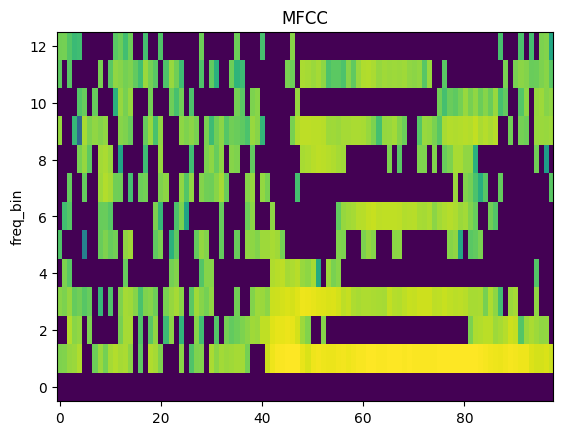

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False},)
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")

backward
backward
backward


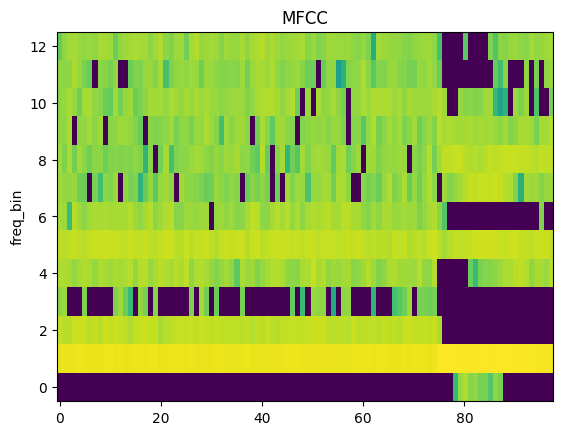

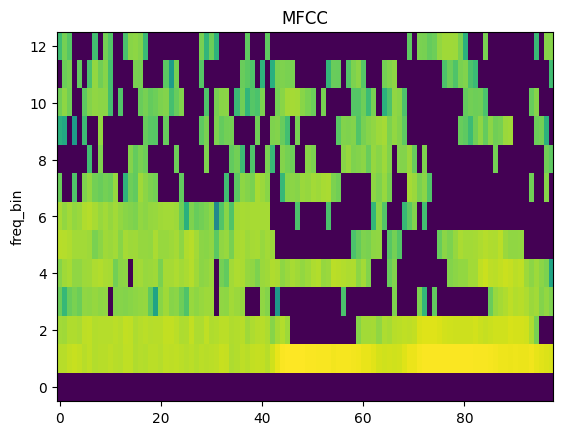

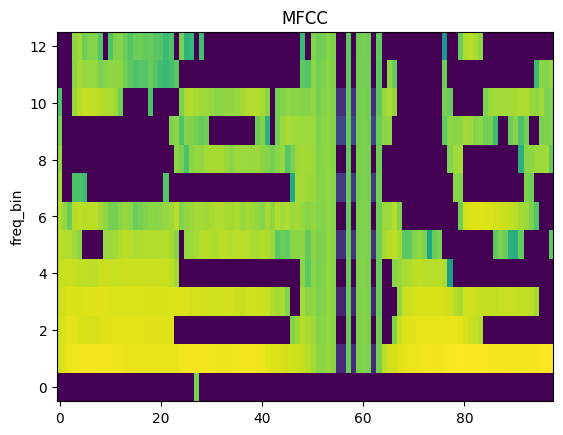

In [ ]:
def aplicar_MFCC (transform, dataset):
  MFCC_dataset = []
  for d in dataset:
    mfcc = transform(d[0])[0]
    delta = torchaudio.functional.compute_deltas(mfcc)
    delta2 = torchaudio.functional.compute_deltas(delta)
    MFCC_dataset.append([mfcc,delta,delta2, d[2]])
  return MFCC_dataset
MFCC_train = aplicar_MFCC(transform, train_dataset)
MFCC_val = aplicar_MFCC(transform, val_dataset)
MFCC_test = aplicar_MFCC(transform, test_dataset)
plot_spectrogram(MFCC_train[0] [0], title="MFCC")
print (MFCC_train[0][3])
plot_spectrogram(MFCC_val[0] [0], title="MFCC")
print (MFCC_val[0][3])
plot_spectrogram(MFCC_test[0] [0], title="MFCC")
print (MFCC_test[0][3])

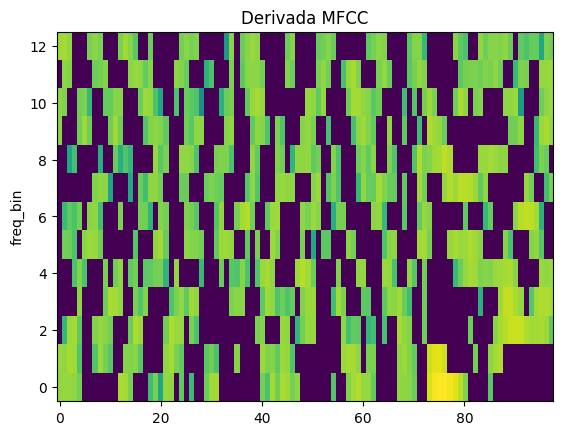

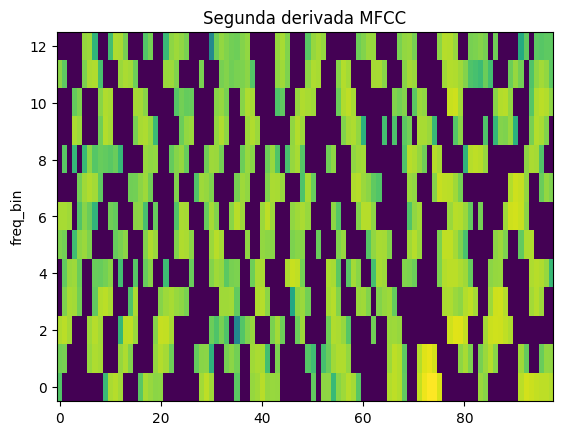

In [ ]:
plot_spectrogram(MFCC_train[0] [1], title="Derivada MFCC")
plot_spectrogram(MFCC_train[0] [2], title="Segunda derivada MFCC")

In [ ]:
print (MFCC_train[0] [0].shape)

torch.Size([13, 98])


## Muestra de los datos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

In [ ]:
total = len (train_dataset) + len (test_dataset) + len (val_dataset)
print (f"Total = {total}")
print (f"Largo train: {len (train_dataset)}")
print (f"% train: {len (train_dataset)/total}")
print (f"Largo test: {len (test_dataset)}")
print (f"% test {len (test_dataset)/total}")
print (f"Largo val: {len (val_dataset)}")
print (f"% val: {len (val_dataset)/total}")

Total = 40709
Largo train: 32453
% train: 0.7971947235255104
Largo test: 4381
% test 0.10761748016409148
Largo val: 3875
% val: 0.0951877963103982


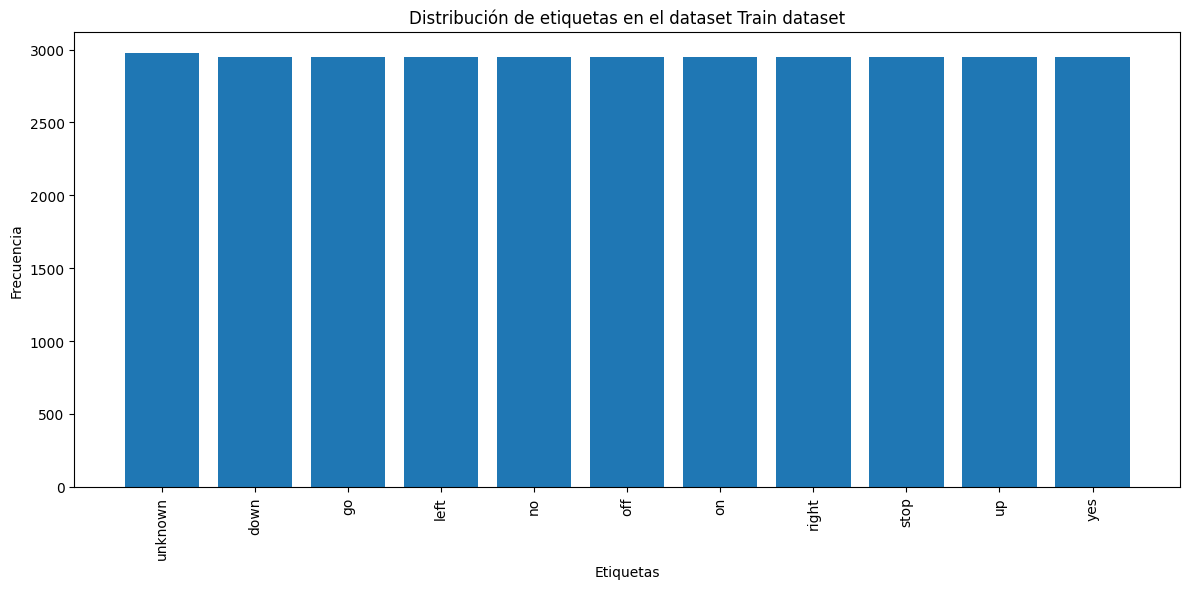

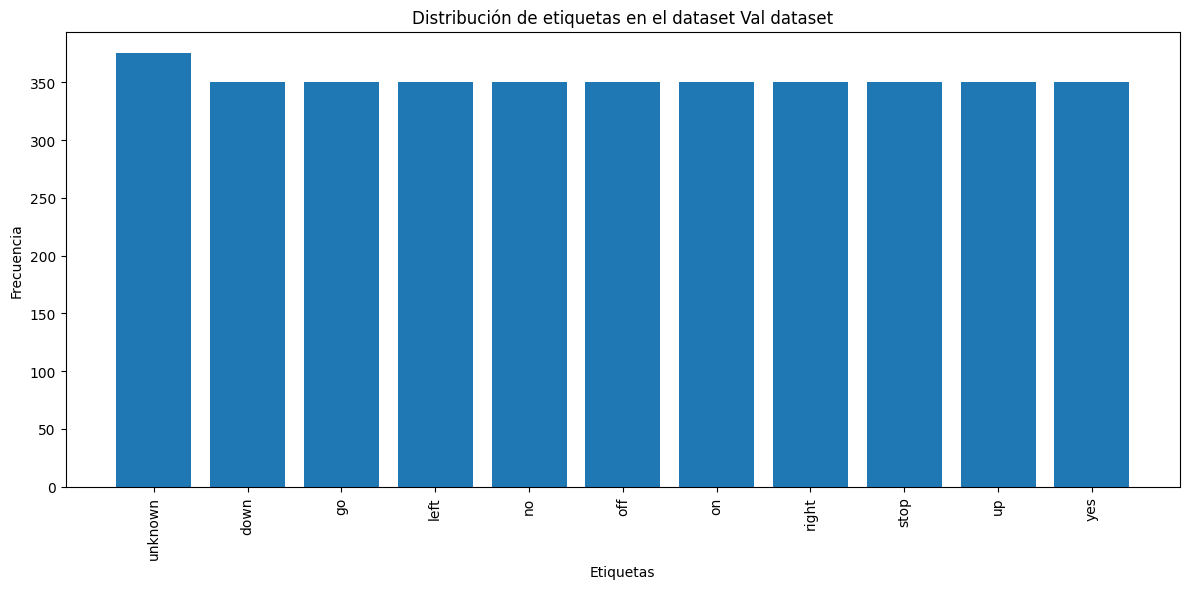

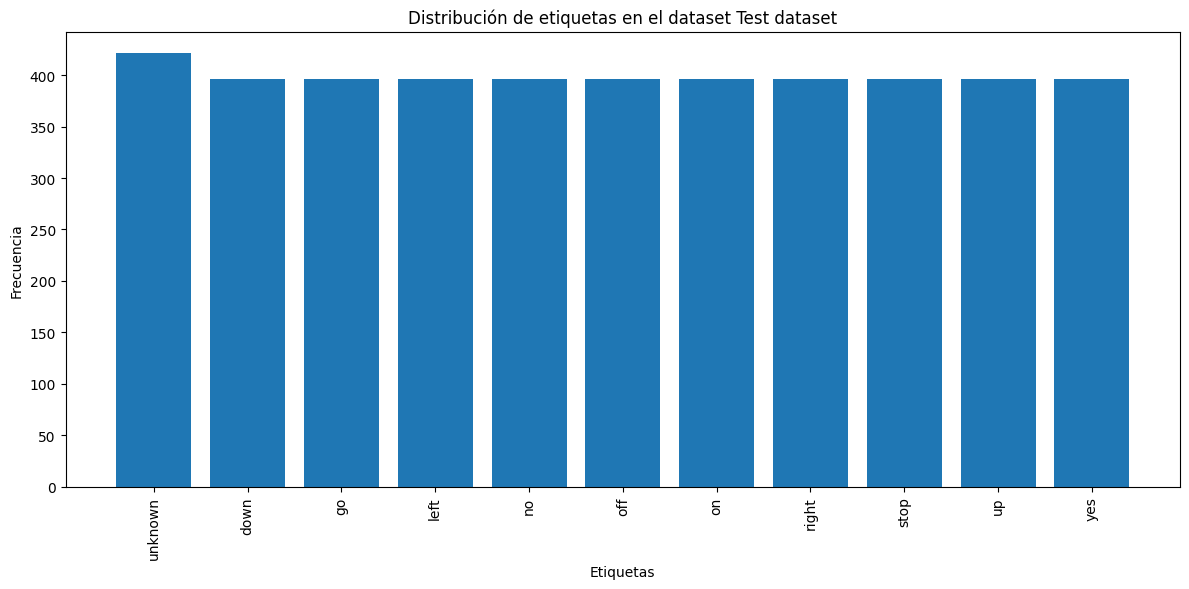

In [ ]:
def plot_labels(dataset, name):
    labels = []

    # extrae solo las etiquetas
    for i in range(len(dataset)):
        item = dataset[i]
        label = item[2] if len(item) > 2 else item[1]
        labels.append(label)

    counts = Counter(labels)
    # 10 etiquetas más frecuentes
    top10 = set([label for label, _ in counts.most_common(10)])
    # clasificar las demás como "unknown"
    labels_clasificadas = [label if label in top10 else "unknown" for label in labels]
    # nuevo conteo con "unknown"
    counts_final = Counter(labels_clasificadas)
    keys = np.array(list(counts_final.keys()))
    values = np.array(list(counts_final.values()), dtype=int)

    plt.figure(figsize=(12, 6))
    plt.bar(keys, values)
    plt.xlabel("Etiquetas")
    plt.ylabel("Frecuencia")
    plt.title(f"Distribución de etiquetas en el dataset {name}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    return labels

labels_train = plot_labels (train_dataset, "Train dataset")
labels_val =plot_labels (val_dataset, "Val dataset")
labels_test =plot_labels (test_dataset, "Test dataset")


In [ ]:
# Supongamos que tienes un elemento del dataset
waveform, sample_rate, label, speaker_id, utterance_number = train_dataset[1000]

# Guardar como archivo wav
torchaudio.save("ejemplo_train.wav", waveform, sample_rate)

print(f"Archivo guardado en ejemplo.wav, clase: {label}")

# Supongamos que tienes un elemento del dataset
waveform, sample_rate, label, speaker_id, utterance_number = val_dataset[500]
# Guardar como archivo wav
torchaudio.save("ejemplo_val.wav", waveform, sample_rate)

print(f"Archivo guardado en ejemplo_val.wav, clase:{label}")

# Supongamos que tienes un elemento del dataset
waveform, sample_rate, label, speaker_id, utterance_number = test_dataset[200]

# Guardar como archivo wav
torchaudio.save("ejemplo_test.wav", waveform, sample_rate)

print(f"Archivo guardado en ejemplo_test.wav, clase:{label}")

Audio("ejemplo_train.wav")

Archivo guardado en ejemplo.wav, clase: down
Archivo guardado en ejemplo_val.wav, clase:go
Archivo guardado en ejemplo_test.wav, clase:down


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:247: UserWarning: torio.io._streaming_media_encoder.StreamingMediaEncoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s 

In [ ]:
Audio("ejemplo_val.wav")

In [ ]:
Audio("ejemplo_test.wav")

In [ ]:
def duracion (dataset):
  list_duration = []
  list_largo = []
  for valor in dataset:
    waveform, _, _,_ ,_ = valor
    num_samples = waveform.shape[-1]
    duracion_segundos = num_samples / sample_rate
    list_duration.append (duracion_segundos)
    list_largo.append (waveform.shape[-1])
  array_duration = np.array (list_duration)
  array_largo = np.array (list_largo)
  print (f"Promedio largo: {np.mean (array_largo)}")
  print (f"Mediana largo: {np.median (array_largo)}")
  print (f"Promedio duración: {np.mean (array_duration)}")
  print (f"Mediana duración: {np.median (array_duration)}")

duracion (train_dataset)
duracion (val_dataset)
duracion (test_dataset)


Promedio largo: 15696.241672572643
Mediana largo: 16000.0
Promedio duración: 0.9810151045357903
Mediana duración: 1.0
Promedio largo: 15716.619612903225
Mediana largo: 16000.0
Promedio duración: 0.9822887258064515
Mediana duración: 1.0
Promedio largo: 15758.10157498288
Mediana largo: 16000.0
Promedio duración: 0.9848813484364303
Mediana duración: 1.0


In [ ]:
def rango(dataset, labels):
    largo = len(np.unique (labels))
    matriz = np.zeros((largo, 3), dtype=object)  # permitir strings y números
    matriz[:, 0] = np.array(np.unique (labels), dtype=object)
    matriz[:, 1] = np.inf
    matriz[:, 2] = -np.inf

    for valor in dataset:
        waveform, _, label, _, _ = valor
        i = np.where(matriz[:, 0] == label)[0]
        matriz[i, 1] = min(waveform.min().item(), matriz[i, 1])
        matriz[i, 2] = max(waveform.max().item(), matriz[i, 2])
    df = pd.DataFrame(matriz)
    df.columns = ['Labels', 'Min', 'Max']
    return df
print (np.unique (labels_train))
print (rango(train_dataset, labels_train))
print (rango(val_dataset, labels_train))
print (rango(test_dataset, labels_train))

['backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'follow'
 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left' 'marvin' 'nine' 'no'
 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree'
 'two' 'up' 'visual' 'wow' 'yes' 'zero']
      Labels       Min       Max
0   backward      -1.0  0.918243
1        bed      -1.0  0.999969
2       bird      -1.0  0.999969
3        cat      -1.0  0.999969
4        dog      -1.0  0.999969
5       down      -1.0  0.999969
6      eight      -1.0  0.999969
7       five      -1.0  0.999969
8     follow      -1.0  0.999969
9    forward -0.879822  0.952911
10      four      -1.0  0.999969
11        go      -1.0  0.999969
12     happy      -1.0  0.999969
13     house      -1.0  0.999969
14     learn      -1.0  0.999969
15      left      -1.0  0.999969
16    marvin      -1.0  0.999969
17      nine      -1.0  0.996643
18        no      -1.0  0.999969
19       off      -1.0  0.999969
20        on      -1.0  0.999969
21       one -0.932

In [ ]:
import pandas as pd

def rango(dataset, labels):
    # etiquetas base conocidas (únicas)
    unique_labels = [str(lbl).strip().lower() for lbl in np.unique(labels)]
    largo = len(unique_labels)
    matriz = np.zeros((largo, 3), dtype=object)
    matriz[:, 0] = np.array(unique_labels, dtype=object)
    matriz[:, 1] = np.inf
    matriz[:, 2] = -np.inf

    for valor in dataset:
        waveform, _, label, _, _ = valor
        label = str(label).strip().lower()  # normaliza
        # si no pertenece al conjunto conocido → usar 'unknown'
        if label not in unique_labels:
            label = 'unknown'

        i = np.where(matriz[:, 0] == label)[0][0]
        matriz[i, 1] = min(waveform.min().item(), matriz[i, 1])
        matriz[i, 2] = max(waveform.max().item(), matriz[i, 2])

    df = pd.DataFrame(matriz, columns=['Label', 'Min', 'Max'])
    return df

# Ejemplo de uso
print("Train:")
print(rango(train_dataset, labels_train), "\n")

print("Validation:")
print(rango(val_dataset, labels_train), "\n")

print("Test:")
print(rango(test_dataset, labels_train))


Train:
       Label       Min       Max
0   backward      -1.0  0.918243
1        bed      -1.0  0.999969
2       bird      -1.0  0.999969
3        cat      -1.0  0.999969
4        dog      -1.0  0.999969
5       down      -1.0  0.999969
6      eight      -1.0  0.999969
7       five      -1.0  0.999969
8     follow      -1.0  0.999969
9    forward -0.879822  0.952911
10      four      -1.0  0.999969
11        go      -1.0  0.999969
12     happy      -1.0  0.999969
13     house      -1.0  0.999969
14     learn      -1.0  0.999969
15      left      -1.0  0.999969
16    marvin      -1.0  0.999969
17      nine      -1.0  0.996643
18        no      -1.0  0.999969
19       off      -1.0  0.999969
20        on      -1.0  0.999969
21       one -0.932587  0.999969
22     right      -1.0  0.999969
23     seven  -0.99939  0.996124
24    sheila      -1.0  0.999969
25       six      -1.0  0.996613
26      stop      -1.0  0.999969
27     three -0.993408  0.993561
28      tree      -1.0  0.999969
29 

## Variación en mfcc

n_ftt: mayor valor, mayor resolución frecuencia y menor temporal (no se detectan cambios rápidos en frecuencia).

hop_lenght: solapamiento. Al aumentar el hop_length, se incrementa la distancia entre cada ventana de análisis. Esto reduce el solapamiento entre las ventanas.  La información sobre eventos acústicos rápidos (como los cambios bruscos en el sonido) se pierde, ya que se están muestreando con menos frecuencia.

## n_fft

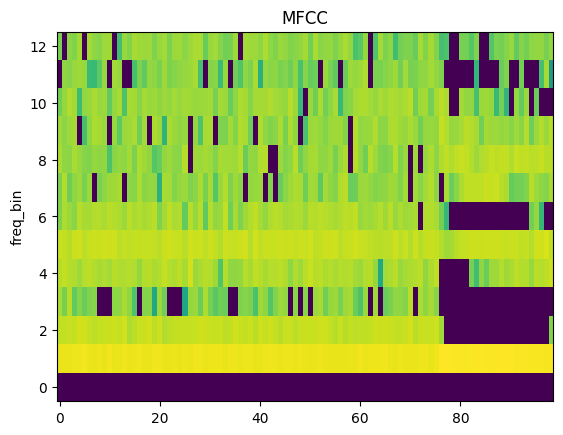

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 200, "hop_length": 160, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")

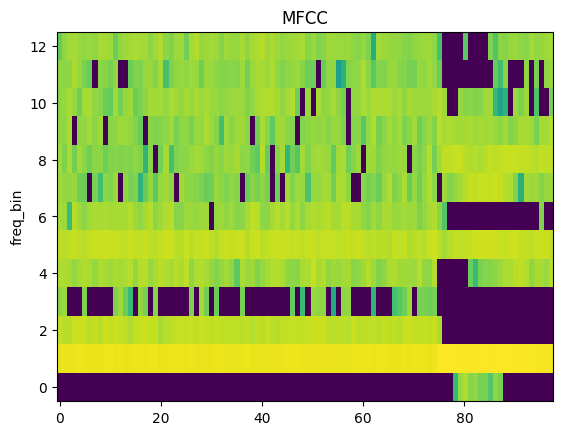

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")

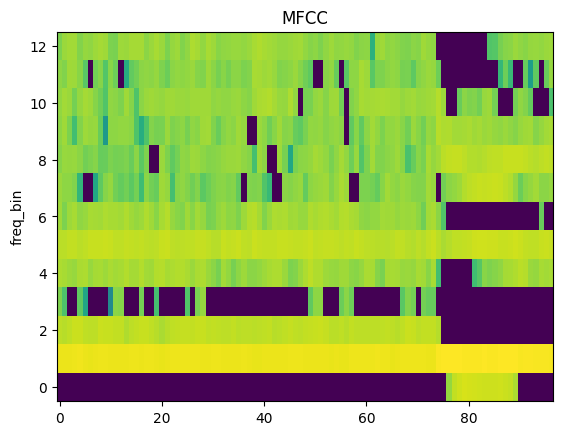

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 600, "hop_length": 160, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")

## hop_lenght

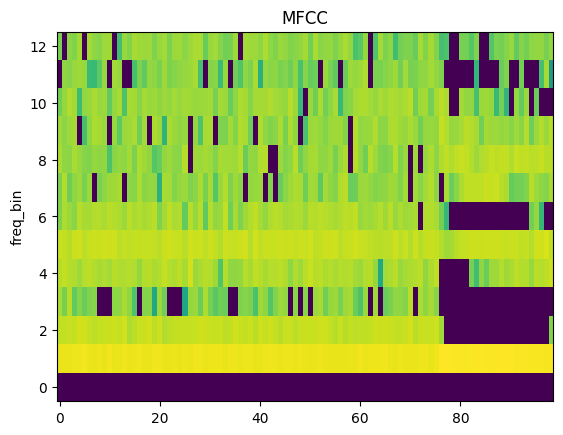

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 200, "hop_length": 160, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")

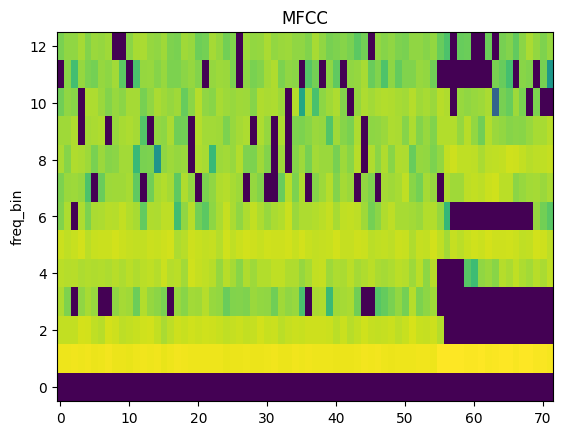

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 200, "hop_length": 220, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")

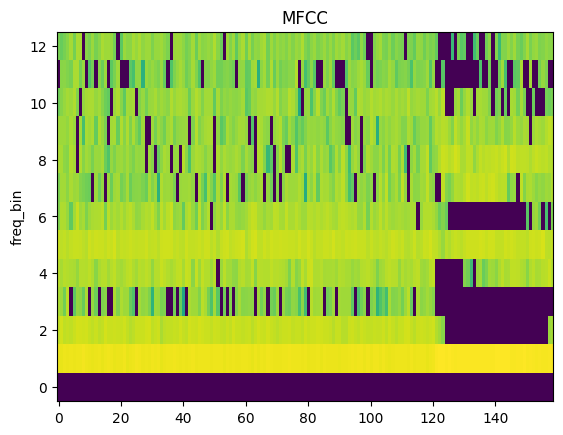

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 200, "hop_length": 100, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")

## Conteo clases más comunes

In [ ]:
# Leer el archivo .txt
with open("train_list.txt", "r") as f:
    lineas = f.readlines()

# Extraer la palabra (carpeta/clase) antes del '/'
clases = [linea.strip().split('/')[0] for linea in lineas]

# Contar cuántos ejemplos hay de cada clase
cuentas = Counter(clases)

# Mostrar las 15 clases más frecuentes
print("15 clases más frecuentes:")
for palabra, cantidad in cuentas.most_common(15):
    print(f"{palabra:10s} : {cantidad}")


15 clases más frecuentes:
yes        : 2948
no         : 2948
up         : 2948
down       : 2948
left       : 2948
right      : 2948
on         : 2948
off        : 2948
stop       : 2948
go         : 2948
backward   : 119
bed        : 119
bird       : 119
cat        : 119
dog        : 119


In [ ]:
clases_10 = ['yes','no','up','down','left','right','on','off','stop','go']

def relabel(dataset,mfc):
    clases10_mf = []
    for wav, sr, label, spk, utn in dataset :
        if label not in mfc:
            label = "unknown"
        clases10_mf.append((wav, sr, label, spk, utn))
    return clases10_mf

train_dataset1 = relabel(train_dataset, clases_10)
val_dataset1   = relabel(val_dataset, clases_10)
test_dataset1  = relabel(test_dataset, clases_10)


In [ ]:
MFCC_train_10 = aplicar_MFCC(transform, train_dataset1)
MFCC_val_10 = aplicar_MFCC(transform, val_dataset1)
MFCC_test_10 = aplicar_MFCC(transform, test_dataset1)

In [ ]:
def adjust_len(tensor, target_len):
    n_features, T = tensor.shape
    if T < target_len:
        # Rellenar con ceros
        tensor = F.pad(tensor, (0, target_len - T))
    elif T > target_len:
        # Recortar si es más largo
        tensor = tensor[:, :target_len]
    return tensor


## Creación de modelos

In [ ]:
class SpeechCommandsMFCC(Dataset):
    def __init__(self, data, target_len):
        self.data = data
        self.target_len = target_len
        labels = sorted(set(d[3] for d in data))
        self.label_num = {lbl:i for i,lbl in enumerate(labels)}

    def __getitem__(self, idx):
        mfcc, d1, d2, label = self.data[idx]
        mfcc  = adjust_len(mfcc,  self.target_len)
        d1    = adjust_len(d1,    self.target_len)
        d2    = adjust_len(d2,    self.target_len)
        x = torch.cat([mfcc, d1, d2], dim=0)
        y = self.label_num[label]
        return x, y

    def __len__(self):
        return len(self.data)


In [ ]:
class RNNVanilla(nn.Module):
    def __init__(self, input_size=39, hidden_size=128, num_layers=1,
                 bidirectional=False, nonlinearity="tanh", num_classes=11):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers,
                          nonlinearity=nonlinearity, bidirectional=bidirectional,
                          batch_first=True)
        bod_ = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(bod_, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)
        _, mf_h = self.rnn(x)
        if self.rnn.bidirectional:
            mf_h_final = torch.cat([mf_h[-2], mf_h[-1]], dim=1)
        else:
            mf_h_final = mf_h[-1]
        return self.fc(mf_h_final)


In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size=39, hidden_size=128, num_layers=1, bidirectional=False, num_classes=11):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        bod_ = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(bod_, num_classes)
    def forward(self, x):
        x = x.transpose(1,2)
        _, h = self.gru(x)
        mf_h_final = torch.cat([h[-2], h[-1]], dim=1) if self.gru.bidirectional else h[-1]
        return self.fc(mf_h_final)


In [ ]:

class LSTMModel(nn.Module):
    def __init__(self, input_size=39, hidden_size=128, num_layers=1, bidirectional=False, num_classes=11):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        bod_ = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(bod_, num_classes)
    def forward(self, x):
        x = x.transpose(1,2)
        _, (h, _) = self.lstm(x)
        mf_h_final = torch.cat([h[-2], h[-1]], dim=1) if self.lstm.bidirectional else h[-1]
        return self.fc(mf_h_final)

In [ ]:
def train_step(x_batch, y_batch, model, optimizer, criterion):
    model.train()
    y_pred = model(x_batch)
    loss = criterion(y_pred, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return y_pred, loss

@torch.no_grad()
def evaluate(val_loader, model, criterion, device="cpu"):
    model.eval()
    cumulative_loss = 0.0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        x_val, y_val = x_val.to(device), y_val.to(device)
        y_predicted = model(x_val)
        loss = criterion(y_predicted, y_val)
        class_prediction = torch.argmax(y_predicted, dim=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.size(0)

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / max(1, len(val_loader))
    return val_acc, val_loss

def train_model(
    model,
    train_loader,
    val_loader,
    epochs,
    criterion,
    lr,
    device="cpu",
    n_evaluations_per_epoch=6,
    early_stopping_patience=None,
):
    if device == "cuda" and torch.cuda.is_available():
        model = model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    curves = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    t0 = time.perf_counter()
    iteration = 0
    n_batches = len(train_loader)

    best_val_acc = -1.0
    best_state = None
    patience = 0

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0.0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.size(0)

            class_prediction = torch.argmax(y_predicted, dim=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % max(1, (n_batches // max(1, n_evaluations_per_epoch))) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count
                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - "
                      f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.2%}")
            iteration += 1

        # validación
        val_acc, val_loss = evaluate(val_loader, model, criterion, device=device)
        train_loss = cumulative_train_loss / max(1, train_loss_count)
        train_acc = cumulative_train_corrects / max(1, train_acc_count)

        print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.2%}")

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        # early stopping
        if early_stopping_patience is not None:
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
                patience = 0
            else:
                patience += 1
                if patience >= early_stopping_patience:
                    print(f"Early stopping: sin mejora en {early_stopping_patience} épocas.")
                    if best_state is not None:
                        model.load_state_dict(best_state)
                    break

    print(f"\nTiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")
    model.cpu()
    return curves



In [ ]:
def adjust_length(T, batch_size=64):
    tr = SpeechCommandsMFCC(MFCC_train_10, target_len=T)
    print(tr.label_num)
    va = SpeechCommandsMFCC(MFCC_val_10,   target_len=T)
    print(va.label_num)
    te = SpeechCommandsMFCC(MFCC_test_10,  target_len=T)
    print(te.label_num)
    return (DataLoader(tr, batch_size=batch_size, shuffle=True),
            DataLoader(va, batch_size=batch_size, shuffle=False),
            DataLoader(te, batch_size=batch_size, shuffle=False))


In [ ]:
def show_curves(curves, title = None, filename = None):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_ylim(0.0,3.0)
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(0.0,1.0)
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename)

    plt.show()


In [ ]:
def show_confusion_matrix(y_true, y_pred, class_names, title=None, normalize=True, filename=None):
    labels = list(range(len(class_names)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)

    fig, ax = plt.subplots(figsize=(7,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, xticks_rotation=45, values_format=".2f" if normalize else "d", colorbar=False)
    ax.set_xlabel("Predicción"); ax.set_ylabel("Verdad")
    ax.set_title(title or "Matriz de confusión")
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=200, bbox_inches="tight")
    plt.show()
    print(classification_report(y_true, y_pred, target_names=class_names))
    # Precisión (Accuracy): porcentaje de predicciones correctas
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Precisión global (Accuracy): {accuracy:.4f}")

In [ ]:
train_dl, val_dl, test_dl = adjust_length(98, batch_size=64)
dataset_instance = test_dl.dataset
num_label = {i: lbl for lbl, i in dataset_instance.label_num.items()}
class_names = [num_label[i] for i in sorted(num_label.keys())]

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}


## Entrenamiento y experimentos

### RNN Vanilla


#### Variación de neuronas por capa

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.2687, Train acc: 18.40%
Iteration 168 - Batch 168/508 - Train loss: 2.1963, Train acc: 21.20%
Iteration 252 - Batch 252/508 - Train loss: 2.1577, Train acc: 22.71%
Iteration 336 - Batch 336/508 - Train loss: 2.1314, Train acc: 23.70%
Iteration 420 - Batch 420/508 - Train loss: 2.1072, Train acc: 24.48%
Iteration 504 - Batch 504/508 - Train loss: 2.0893, Train acc: 25.37%
Val loss: 1.9883, Val acc: 29.39%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 1.9864, Train acc: 29.96%
Iteration 676 - Batch 168/508 - Train loss: 1.9641, Train acc: 30.96%
Iteration 760 - Batch 252/508 - Trai

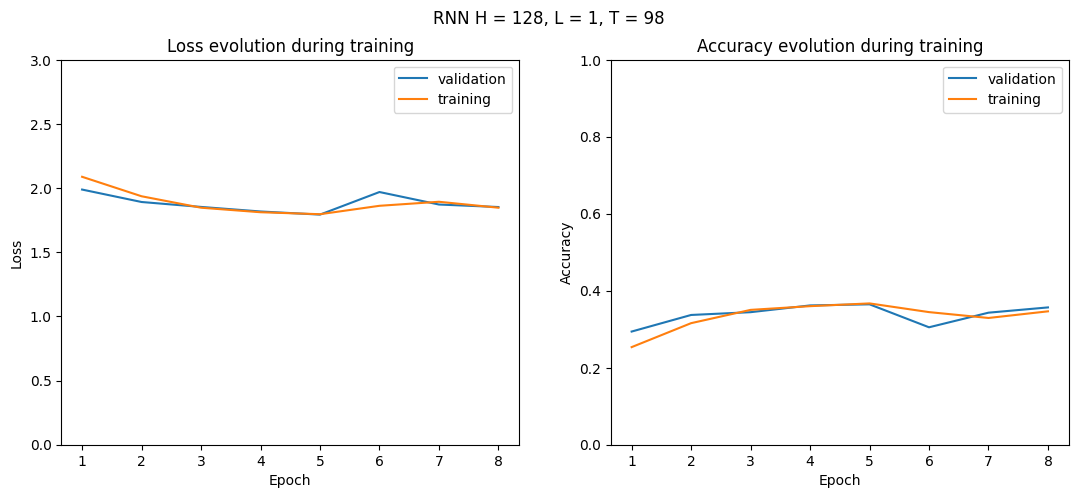

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

clases_10 = ['down','go','left','no','off','on','right','stop','unkwown','up', "yes"]
train_dl, val_dl, test_dl = adjust_length(98, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="RNN H = 128, L = 1, T = 98", filename="rnn_vanilla_h=128.png")

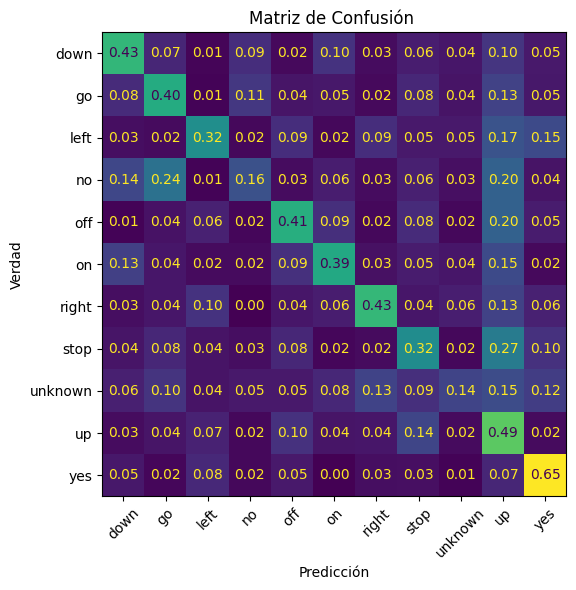

              precision    recall  f1-score   support

        down       0.42      0.43      0.43       396
          go       0.36      0.40      0.38       396
        left       0.43      0.32      0.37       396
          no       0.31      0.16      0.21       396
         off       0.41      0.41      0.41       396
          on       0.44      0.39      0.42       396
       right       0.49      0.43      0.46       396
        stop       0.32      0.32      0.32       396
     unknown       0.30      0.14      0.19       421
          up       0.23      0.49      0.32       396
         yes       0.50      0.65      0.56       396

    accuracy                           0.38      4381
   macro avg       0.38      0.38      0.37      4381
weighted avg       0.38      0.38      0.37      4381

Precisión global (Accuracy): 0.3759


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión ", filename = "matriz_de_confusión_H=128")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.3668, Train acc: 14.26%
Iteration 168 - Batch 168/508 - Train loss: 2.3091, Train acc: 16.74%
Iteration 252 - Batch 252/508 - Train loss: 2.2653, Train acc: 18.87%
Iteration 336 - Batch 336/508 - Train loss: 2.2316, Train acc: 20.23%
Iteration 420 - Batch 420/508 - Train loss: 2.2030, Train acc: 21.54%
Iteration 504 - Batch 504/508 - Train loss: 2.1810, Train acc: 22.29%
Val loss: 2.0541, Val acc: 27.20%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 2.0604, Train acc: 27.00%
Iteration 676 - Batch 168/508 - Train loss: 2.0510, Train acc: 27.21%
Iteration 760 - Batch 252/508 - Trai

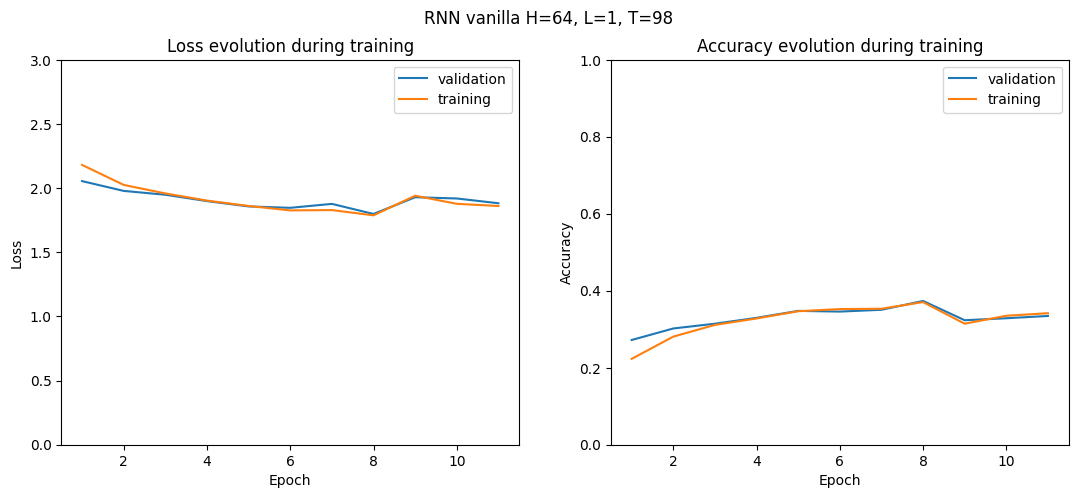

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(98, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=64, num_layers=1,
                   bidirectional=False, nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="RNN vanilla H=64, L=1, T=98", filename="rnn_vanilla_H=64.png")

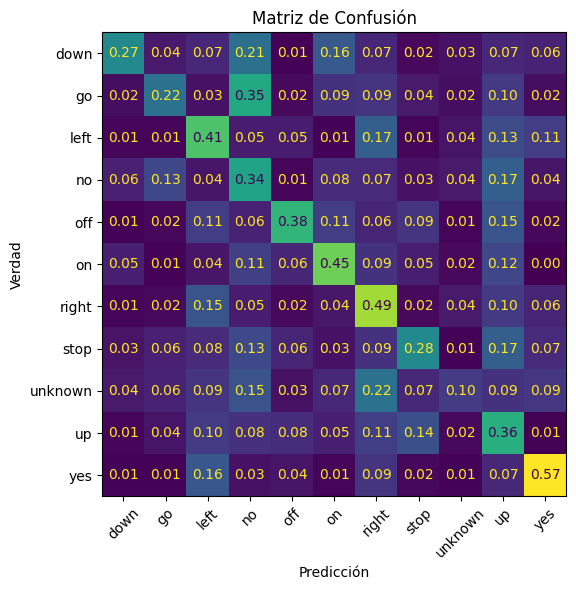

              precision    recall  f1-score   support

        down       0.51      0.27      0.35       396
          go       0.36      0.22      0.27       396
        left       0.33      0.41      0.36       396
          no       0.22      0.34      0.26       396
         off       0.51      0.38      0.43       396
          on       0.41      0.45      0.43       396
       right       0.32      0.49      0.39       396
        stop       0.36      0.28      0.31       396
     unknown       0.32      0.10      0.15       421
          up       0.24      0.36      0.29       396
         yes       0.54      0.57      0.56       396

    accuracy                           0.35      4381
   macro avg       0.37      0.35      0.35      4381
weighted avg       0.37      0.35      0.35      4381

Precisión global (Accuracy): 0.3506


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matriz_de_confusión_H=64")


{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.2192, Train acc: 20.35%
Iteration 168 - Batch 168/508 - Train loss: 2.1522, Train acc: 22.94%
Iteration 252 - Batch 252/508 - Train loss: 2.1109, Train acc: 24.69%
Iteration 336 - Batch 336/508 - Train loss: 2.0885, Train acc: 25.75%
Iteration 420 - Batch 420/508 - Train loss: 2.0661, Train acc: 26.64%
Iteration 504 - Batch 504/508 - Train loss: 2.0465, Train acc: 27.36%
Val loss: 1.9106, Val acc: 32.21%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 1.9096, Train acc: 31.60%
Iteration 676 - Batch 168/508 - Train loss: 1.8947, Train acc: 32.86%
Iteration 760 - Batch 252/508 - Trai

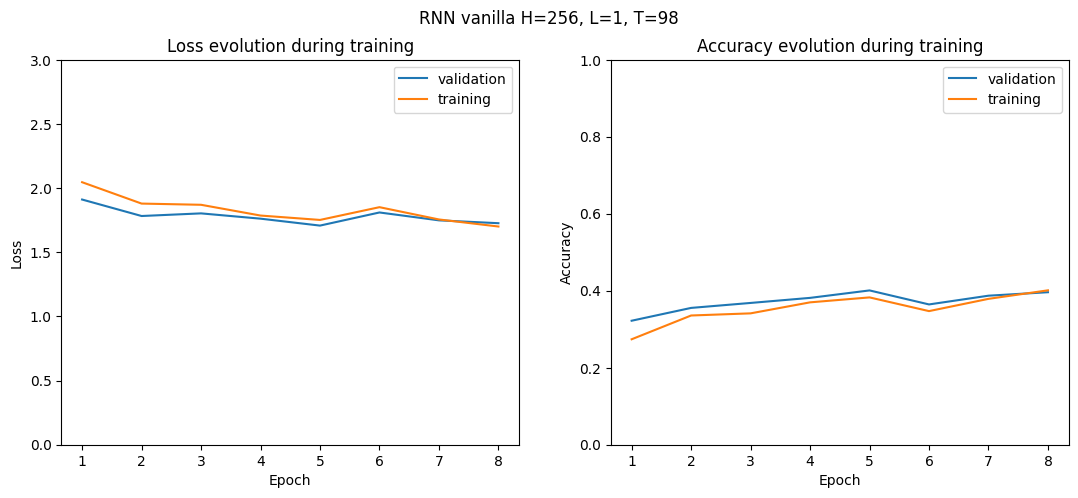

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(98, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=256, num_layers=1,
                   bidirectional=False, nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="RNN vanilla H=256, L=1, T=98", filename="rnn_vanilla_H=256.png")

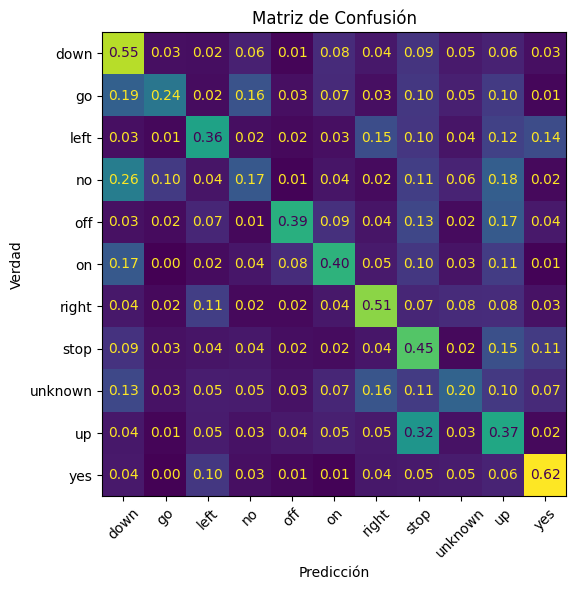

              precision    recall  f1-score   support

        down       0.35      0.55      0.43       396
          go       0.50      0.24      0.33       396
        left       0.41      0.36      0.38       396
          no       0.27      0.17      0.21       396
         off       0.60      0.39      0.47       396
          on       0.45      0.40      0.42       396
       right       0.46      0.51      0.48       396
        stop       0.28      0.45      0.34       396
     unknown       0.34      0.20      0.25       421
          up       0.24      0.37      0.29       396
         yes       0.57      0.62      0.59       396

    accuracy                           0.39      4381
   macro avg       0.41      0.39      0.38      4381
weighted avg       0.41      0.39      0.38      4381

Precisión global (Accuracy): 0.3851


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matriz_de_confusión_h=256")


#### Variación número de capas

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.2279, Train acc: 19.67%
Iteration 168 - Batch 168/508 - Train loss: 2.1661, Train acc: 21.99%
Iteration 252 - Batch 252/508 - Train loss: 2.1510, Train acc: 22.81%
Iteration 336 - Batch 336/508 - Train loss: 2.1617, Train acc: 22.61%
Iteration 420 - Batch 420/508 - Train loss: 2.1462, Train acc: 23.15%
Iteration 504 - Batch 504/508 - Train loss: 2.1277, Train acc: 23.95%
Val loss: 2.0103, Val acc: 28.41%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 1.9404, Train acc: 31.21%
Iteration 676 - Batch 168/508 - Train loss: 2.0175, Train acc: 28.56%
Iteration 760 - Batch 252/508 - Trai

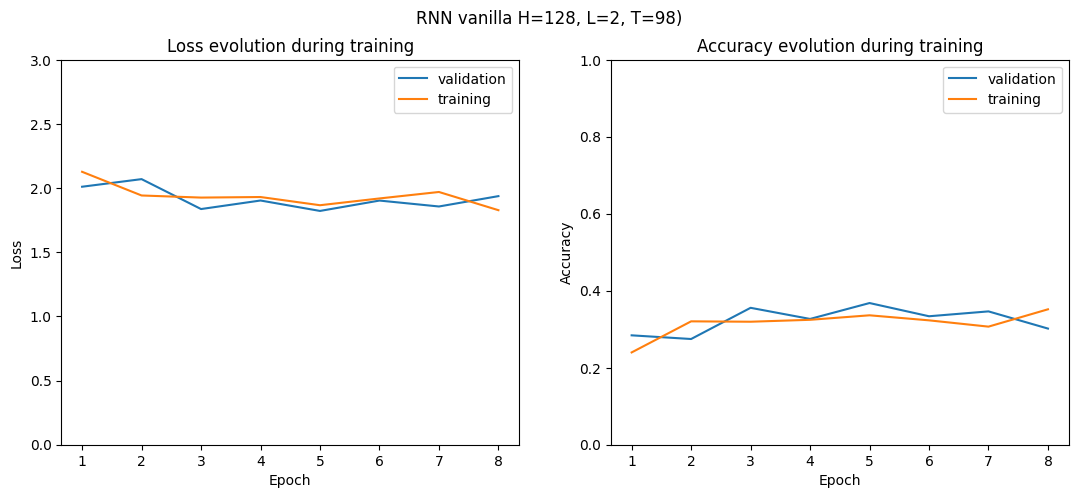

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(98, batch_size=64)

model =RNNVanilla(input_size=39, hidden_size=128, num_layers=2,
                   bidirectional=False,nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="RNN vanilla H=128, L=2, T=98)", filename="gru_vanilla_L=2.png")

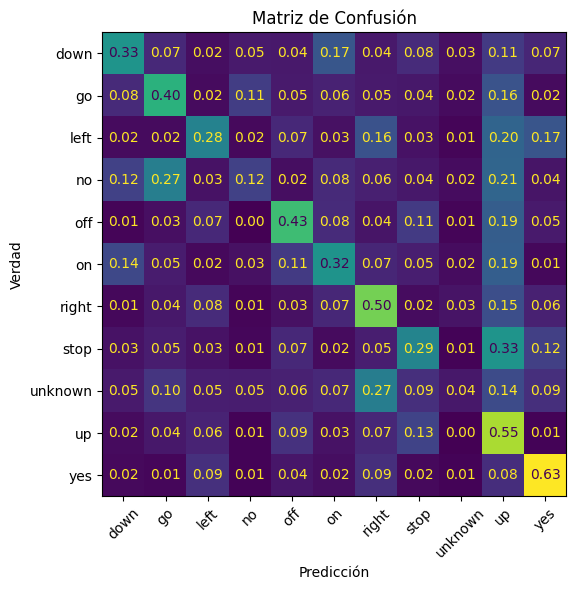

              precision    recall  f1-score   support

        down       0.40      0.33      0.36       396
          go       0.37      0.40      0.39       396
        left       0.37      0.28      0.32       396
          no       0.30      0.12      0.17       396
         off       0.43      0.43      0.43       396
          on       0.34      0.32      0.33       396
       right       0.36      0.50      0.42       396
        stop       0.32      0.29      0.30       396
     unknown       0.23      0.04      0.07       421
          up       0.24      0.55      0.33       396
         yes       0.51      0.63      0.56       396

    accuracy                           0.35      4381
   macro avg       0.35      0.35      0.33      4381
weighted avg       0.35      0.35      0.33      4381

Precisión global (Accuracy): 0.3524


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matriz_de_confusión_L=2")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.2132, Train acc: 19.71%
Iteration 168 - Batch 168/508 - Train loss: 2.1526, Train acc: 22.08%
Iteration 252 - Batch 252/508 - Train loss: 2.1396, Train acc: 22.64%
Iteration 336 - Batch 336/508 - Train loss: 2.1116, Train acc: 23.85%
Iteration 420 - Batch 420/508 - Train loss: 2.1000, Train acc: 24.38%
Iteration 504 - Batch 504/508 - Train loss: 2.0890, Train acc: 24.90%
Val loss: 2.0028, Val acc: 28.90%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 2.0032, Train acc: 28.16%
Iteration 676 - Batch 168/508 - Train loss: 1.9796, Train acc: 29.55%
Iteration 760 - Batch 252/508 - Trai

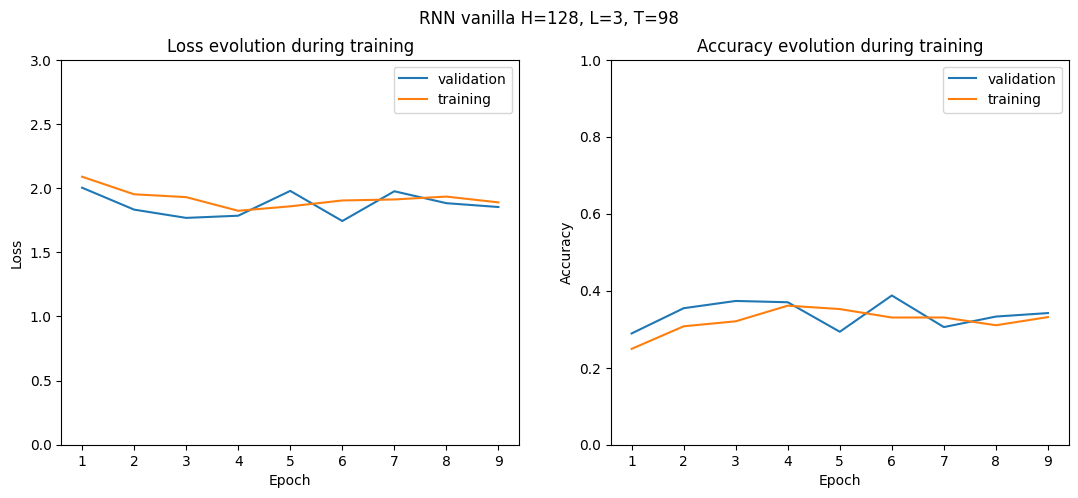

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_dl, val_dl, test_dl = adjust_length(98, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=128, num_layers=3,
                   bidirectional=False, nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="RNN vanilla H=128, L=3, T=98", filename="gru_vanilla_L=3.png")

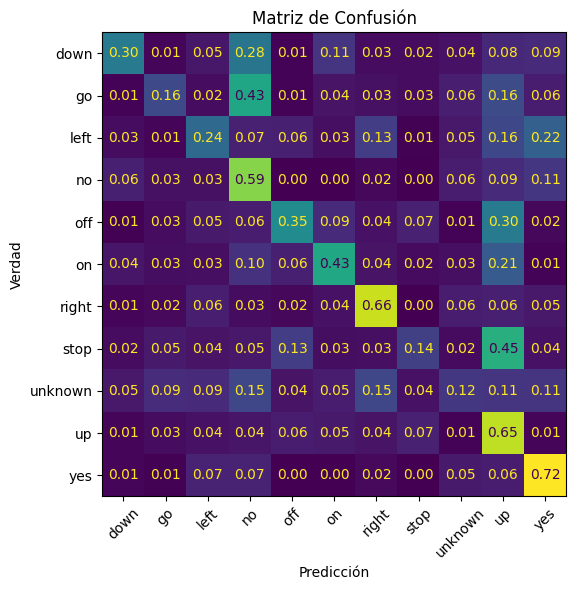

              precision    recall  f1-score   support

        down       0.54      0.30      0.38       396
          go       0.34      0.16      0.22       396
        left       0.34      0.24      0.28       396
          no       0.31      0.59      0.41       396
         off       0.47      0.35      0.40       396
          on       0.49      0.43      0.46       396
       right       0.56      0.66      0.60       396
        stop       0.36      0.14      0.20       396
     unknown       0.25      0.12      0.16       421
          up       0.28      0.65      0.39       396
         yes       0.51      0.72      0.59       396

    accuracy                           0.39      4381
   macro avg       0.40      0.40      0.37      4381
weighted avg       0.40      0.39      0.37      4381

Precisión global (Accuracy): 0.3937


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "LM_matriz_de_confusión_L=3")

#### Variación largo de secuencia

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.3203, Train acc: 16.08%
Iteration 168 - Batch 168/508 - Train loss: 2.2583, Train acc: 18.71%
Iteration 252 - Batch 252/508 - Train loss: 2.2265, Train acc: 19.69%
Iteration 336 - Batch 336/508 - Train loss: 2.2035, Train acc: 20.52%
Iteration 420 - Batch 420/508 - Train loss: 2.1836, Train acc: 21.24%
Iteration 504 - Batch 504/508 - Train loss: 2.1724, Train acc: 21.81%
Val loss: 2.0793, Val acc: 24.26%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 2.0764, Train acc: 25.86%
Iteration 676 - Batch 168/508 - Train loss: 2.0717, Train acc: 25.69%
Iteration 760 - Batch 252/508 - Trai

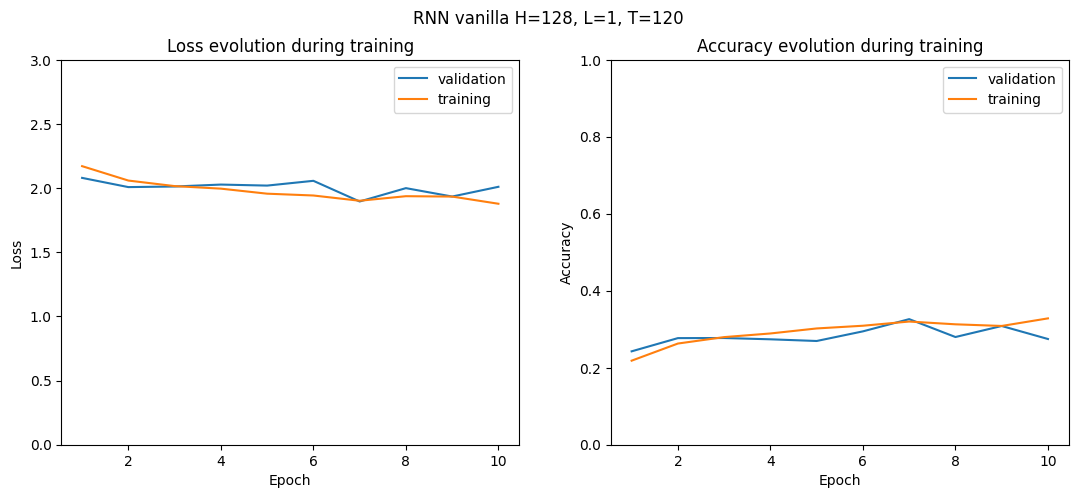

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_dl, val_dl, test_dl = adjust_length(120, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=True,nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="RNN vanilla H=128, L=1, T=120" , filename="gru_vanilla_B=TRUE.png")

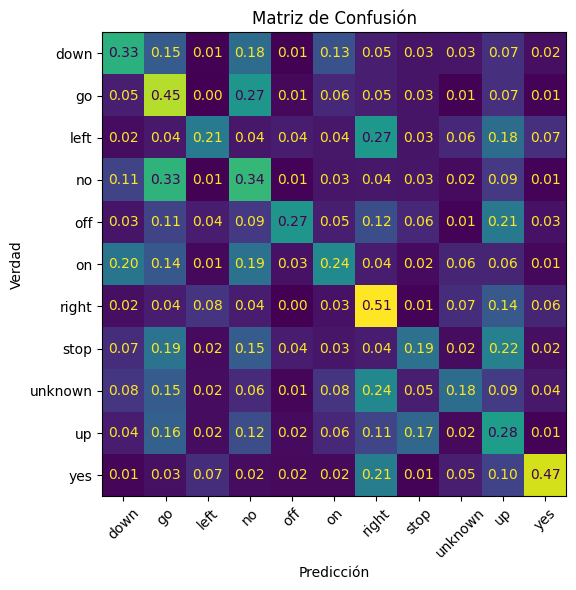

              precision    recall  f1-score   support

        down       0.34      0.33      0.33       396
          go       0.25      0.45      0.32       396
        left       0.44      0.21      0.29       396
          no       0.23      0.34      0.27       396
         off       0.59      0.27      0.37       396
          on       0.32      0.24      0.28       396
       right       0.30      0.51      0.38       396
        stop       0.31      0.19      0.24       396
     unknown       0.37      0.18      0.24       421
          up       0.19      0.28      0.22       396
         yes       0.63      0.47      0.54       396

    accuracy                           0.32      4381
   macro avg       0.36      0.32      0.32      4381
weighted avg       0.36      0.32      0.32      4381

Precisión global (Accuracy): 0.3152


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "RNN_matriz_de_confusión_b=True")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.3341, Train acc: 16.14%
Iteration 168 - Batch 168/508 - Train loss: 2.2668, Train acc: 18.62%
Iteration 252 - Batch 252/508 - Train loss: 2.2229, Train acc: 20.52%
Iteration 336 - Batch 336/508 - Train loss: 2.1977, Train acc: 21.54%
Iteration 420 - Batch 420/508 - Train loss: 2.1772, Train acc: 22.36%
Iteration 504 - Batch 504/508 - Train loss: 2.1615, Train acc: 22.81%
Val loss: 2.0966, Val acc: 25.47%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 2.0656, Train acc: 26.34%
Iteration 676 - Batch 168/508 - Train loss: 2.0537, Train acc: 27.10%
Iteration 760 - Batch 252/508 - Trai

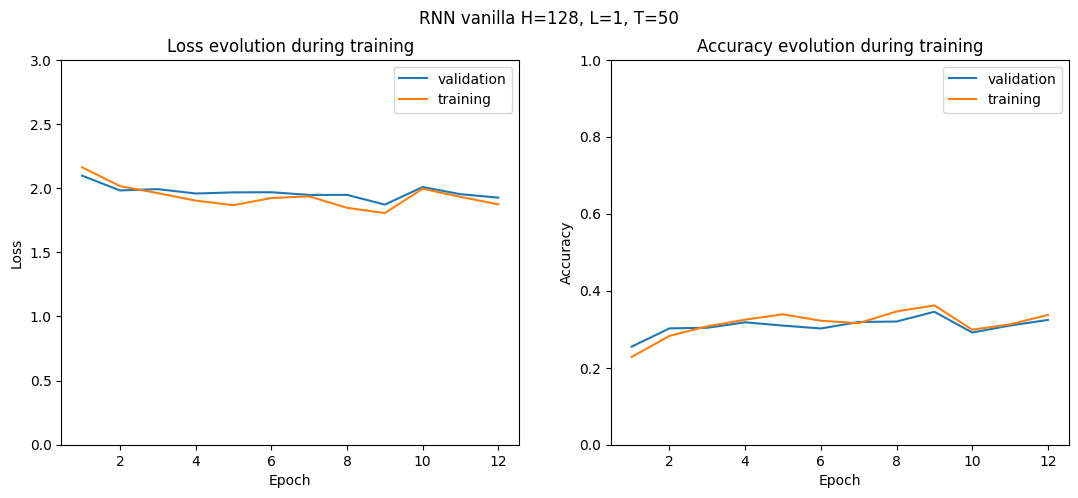

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(50, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False,nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="RNN vanilla H=128, L=1, T=50", filename="rnn_vanilla_relu.png")

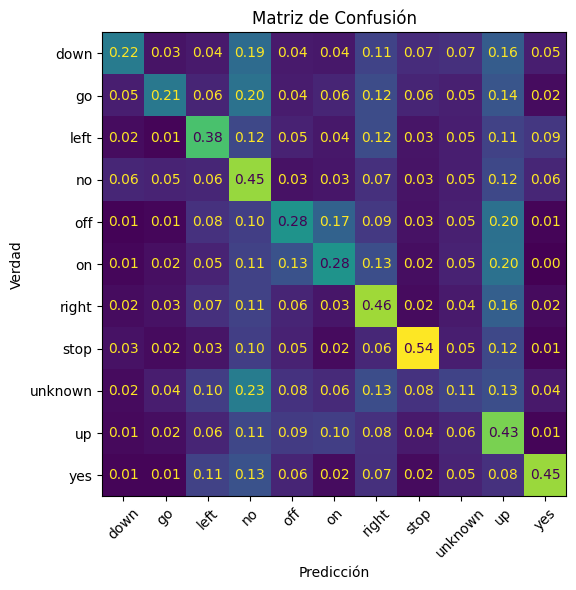

              precision    recall  f1-score   support

        down       0.51      0.22      0.31       396
          go       0.48      0.21      0.30       396
        left       0.37      0.38      0.38       396
          no       0.24      0.45      0.32       396
         off       0.31      0.28      0.29       396
          on       0.33      0.28      0.30       396
       right       0.32      0.46      0.38       396
        stop       0.59      0.54      0.56       396
     unknown       0.18      0.11      0.14       421
          up       0.23      0.43      0.30       396
         yes       0.62      0.45      0.52       396

    accuracy                           0.34      4381
   macro avg       0.38      0.35      0.34      4381
weighted avg       0.38      0.34      0.34      4381

Precisión global (Accuracy): 0.3444


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matriz_de_confusión_relu")

Extras

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.2735, Train acc: 18.14%
Iteration 168 - Batch 168/508 - Train loss: 2.2009, Train acc: 20.84%
Iteration 252 - Batch 252/508 - Train loss: 2.1567, Train acc: 22.51%
Iteration 336 - Batch 336/508 - Train loss: 2.1279, Train acc: 23.56%
Iteration 420 - Batch 420/508 - Train loss: 2.1038, Train acc: 24.67%
Iteration 504 - Batch 504/508 - Train loss: 2.0859, Train acc: 25.35%
Val loss: 1.9675, Val acc: 29.19%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 1.9537, Train acc: 30.17%
Iteration 676 - Batch 168/508 - Train loss: 1.9380, Train acc: 30.86%
Iteration 760 - Batch 252/508 - Trai

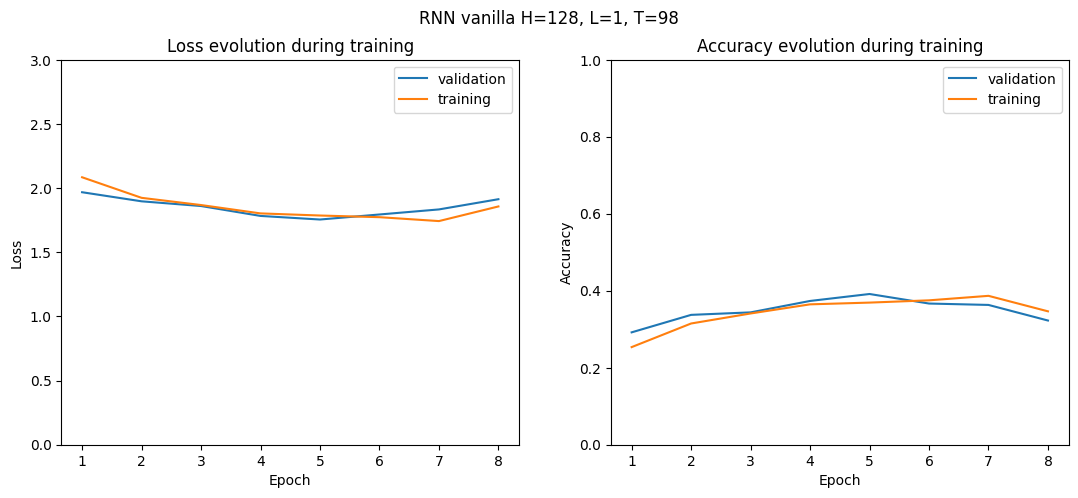

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(98, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=True, nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="RNN vanilla H=128, L=1, T=98", filename="rnn_vanilla_T=50.png")

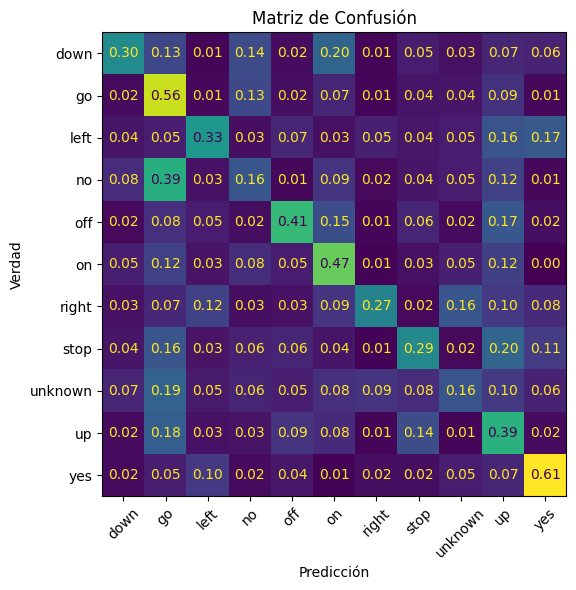

              precision    recall  f1-score   support

        down       0.44      0.30      0.35       396
          go       0.28      0.56      0.38       396
        left       0.41      0.33      0.36       396
          no       0.21      0.16      0.19       396
         off       0.48      0.41      0.44       396
          on       0.36      0.47      0.41       396
       right       0.54      0.27      0.36       396
        stop       0.36      0.29      0.32       396
     unknown       0.27      0.16      0.20       421
          up       0.25      0.39      0.30       396
         yes       0.53      0.61      0.57       396

    accuracy                           0.36      4381
   macro avg       0.38      0.36      0.35      4381
weighted avg       0.37      0.36      0.35      4381

Precisión global (Accuracy): 0.3579


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matriz_de_confusión_T=50")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.3116, Train acc: 16.43%
Iteration 168 - Batch 168/508 - Train loss: 2.2623, Train acc: 18.32%
Iteration 252 - Batch 252/508 - Train loss: 2.2303, Train acc: 19.73%
Iteration 336 - Batch 336/508 - Train loss: 2.2092, Train acc: 20.62%
Iteration 420 - Batch 420/508 - Train loss: 2.1875, Train acc: 21.61%
Iteration 504 - Batch 504/508 - Train loss: 2.1681, Train acc: 22.39%
Val loss: 2.0930, Val acc: 25.78%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 2.0436, Train acc: 27.52%
Iteration 676 - Batch 168/508 - Train loss: 2.0441, Train acc: 27.59%
Iteration 760 - Batch 252/508 - Trai

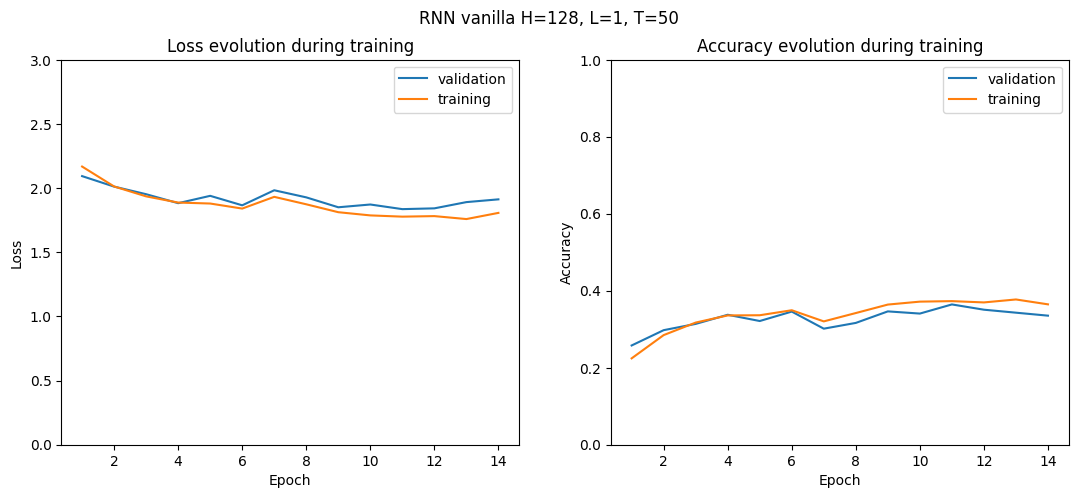

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(50, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=True, nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="RNN vanilla H=128, L=1, T=50", filename="rnn_vanilla_T=120.png")

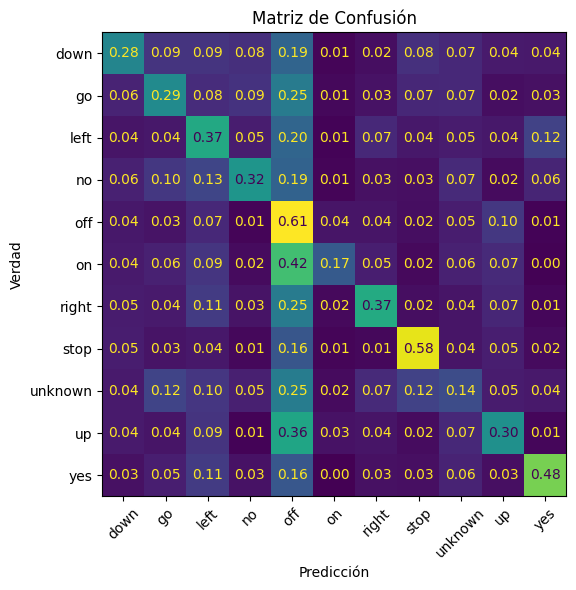

              precision    recall  f1-score   support

        down       0.38      0.28      0.32       396
          go       0.32      0.29      0.31       396
        left       0.29      0.37      0.32       396
          no       0.45      0.32      0.37       396
         off       0.20      0.61      0.30       396
          on       0.55      0.17      0.26       396
       right       0.49      0.37      0.42       396
        stop       0.57      0.58      0.57       396
     unknown       0.21      0.14      0.17       421
          up       0.39      0.30      0.34       396
         yes       0.59      0.48      0.53       396

    accuracy                           0.35      4381
   macro avg       0.40      0.36      0.36      4381
weighted avg       0.40      0.35      0.35      4381

Precisión global (Accuracy): 0.3538


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matriz_de_confusión_T=120")

### Modelo gru

#### Variación número de neuronas por capa

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.0601, Train acc: 32.78%
Iteration 168 - Batch 168/508 - Train loss: 1.7591, Train acc: 44.86%
Iteration 252 - Batch 252/508 - Train loss: 1.5310, Train acc: 52.53%
Iteration 336 - Batch 336/508 - Train loss: 1.3767, Train acc: 57.31%
Iteration 420 - Batch 420/508 - Train loss: 1.2565, Train acc: 60.99%
Iteration 504 - Batch 504/508 - Train loss: 1.1674, Train acc: 63.69%
Val loss: 0.7215, Val acc: 76.21%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.6199, Train acc: 80.26%
Iteration 676 - Batch 168/508 - Train loss: 0.6299, Train acc: 79.83%
Iteration 760 - Batch 252/508 - Trai

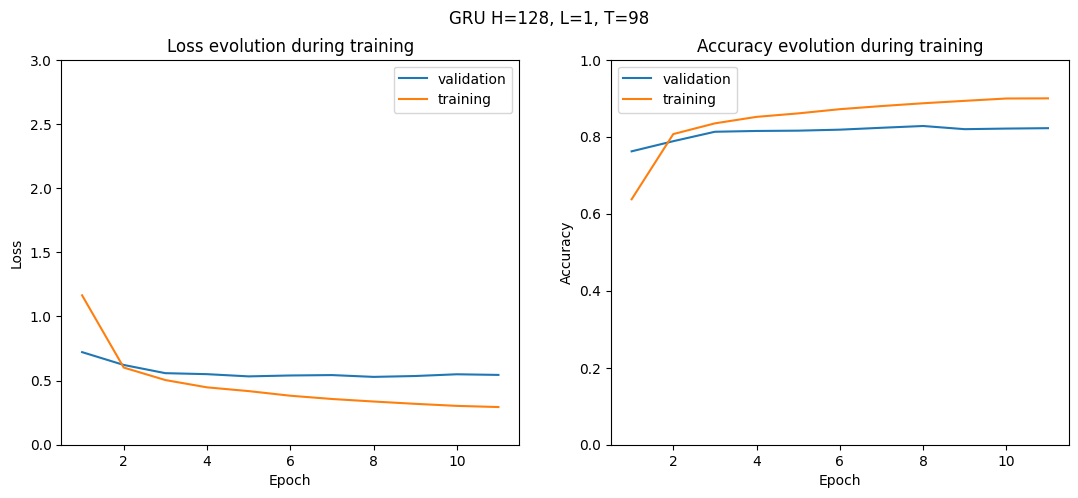

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(98, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="GRU H=128, L=1, T=98", filename="gru_h=128.png")

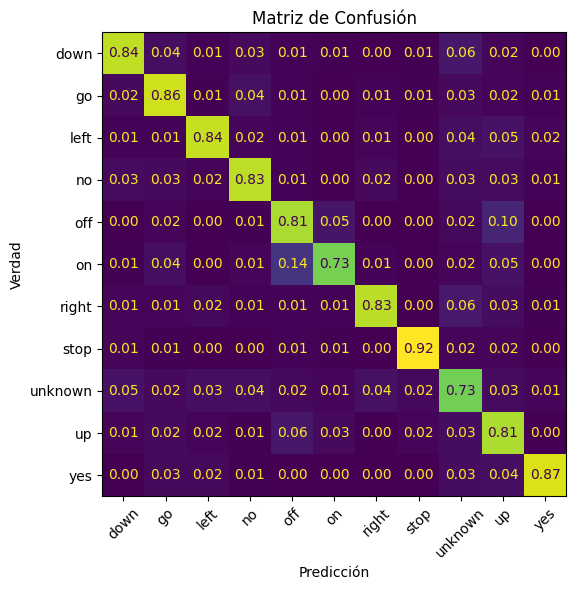

              precision    recall  f1-score   support

        down       0.84      0.84      0.84       396
          go       0.80      0.86      0.83       396
        left       0.87      0.84      0.86       396
          no       0.84      0.83      0.84       396
         off       0.74      0.81      0.77       396
          on       0.86      0.73      0.79       396
       right       0.89      0.83      0.86       396
        stop       0.95      0.92      0.94       396
     unknown       0.70      0.73      0.72       421
          up       0.69      0.81      0.75       396
         yes       0.94      0.87      0.90       396

    accuracy                           0.82      4381
   macro avg       0.83      0.82      0.83      4381
weighted avg       0.83      0.82      0.83      4381

Precisión global (Accuracy): 0.8242


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_h=128")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.8473, Train acc: 39.15%
Iteration 168 - Batch 168/508 - Train loss: 1.4480, Train acc: 53.53%
Iteration 252 - Batch 252/508 - Train loss: 1.2332, Train acc: 60.51%
Iteration 336 - Batch 336/508 - Train loss: 1.1038, Train acc: 64.46%
Iteration 420 - Batch 420/508 - Train loss: 1.0112, Train acc: 67.45%
Iteration 504 - Batch 504/508 - Train loss: 0.9438, Train acc: 69.53%
Val loss: 0.6234, Val acc: 77.94%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.5511, Train acc: 81.84%
Iteration 676 - Batch 168/508 - Train loss: 0.5363, Train acc: 82.27%
Iteration 760 - Batch 252/508 - Trai

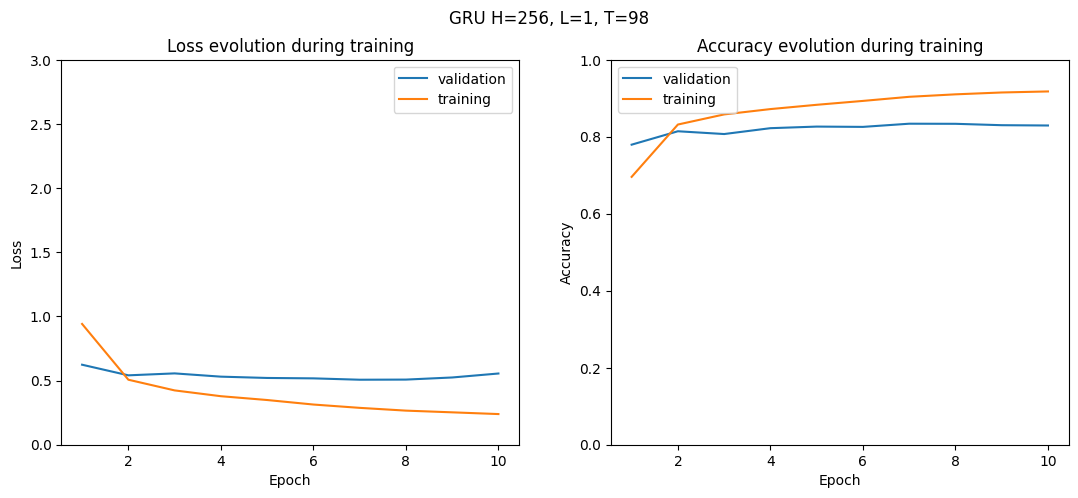

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(98, batch_size=64)

model = GRUModel(input_size=39, hidden_size=256, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="GRU H=256, L=1, T=98", filename="gru_h=256.png")

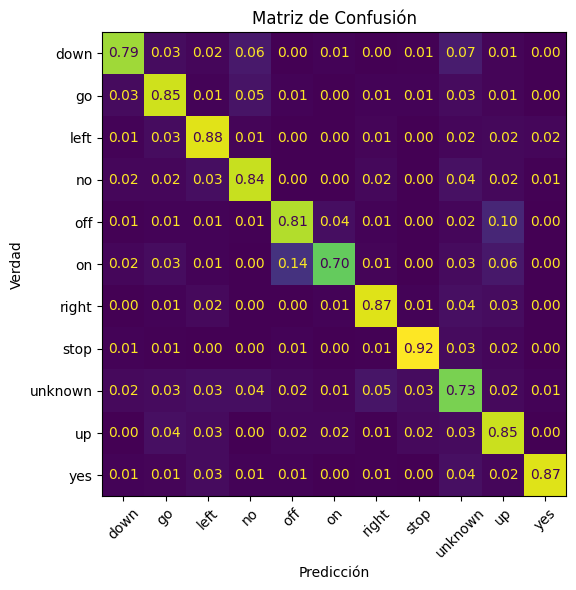

              precision    recall  f1-score   support

        down       0.87      0.79      0.83       396
          go       0.80      0.85      0.82       396
        left       0.82      0.88      0.85       396
          no       0.82      0.84      0.83       396
         off       0.80      0.81      0.81       396
          on       0.89      0.70      0.79       396
       right       0.86      0.87      0.87       396
        stop       0.91      0.92      0.92       396
     unknown       0.70      0.73      0.72       421
          up       0.73      0.85      0.78       396
         yes       0.96      0.87      0.91       396

    accuracy                           0.83      4381
   macro avg       0.83      0.83      0.83      4381
weighted avg       0.83      0.83      0.83      4381

Precisión global (Accuracy): 0.8288


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_h=256")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.2102, Train acc: 23.95%
Iteration 168 - Batch 168/508 - Train loss: 2.0179, Train acc: 33.43%
Iteration 252 - Batch 252/508 - Train loss: 1.8648, Train acc: 39.37%
Iteration 336 - Batch 336/508 - Train loss: 1.7283, Train acc: 44.46%
Iteration 420 - Batch 420/508 - Train loss: 1.6129, Train acc: 48.61%
Iteration 504 - Batch 504/508 - Train loss: 1.5194, Train acc: 51.78%
Val loss: 0.9757, Val acc: 69.96%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.9297, Train acc: 70.74%
Iteration 676 - Batch 168/508 - Train loss: 0.9073, Train acc: 71.36%
Iteration 760 - Batch 252/508 - Trai

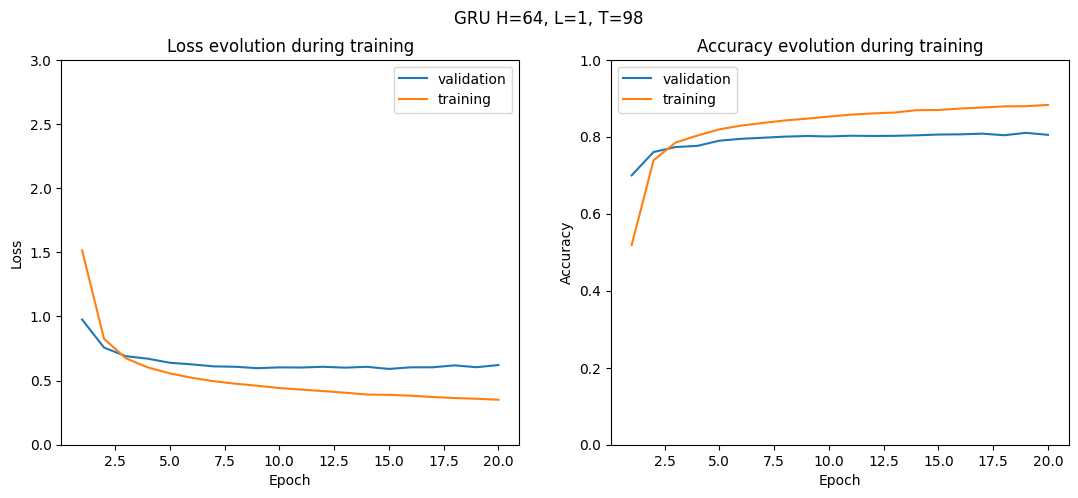

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(98, batch_size=64)

model = GRUModel(input_size=39, hidden_size=64, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="GRU H=64, L=1, T=98", filename="gru_h=64.png")

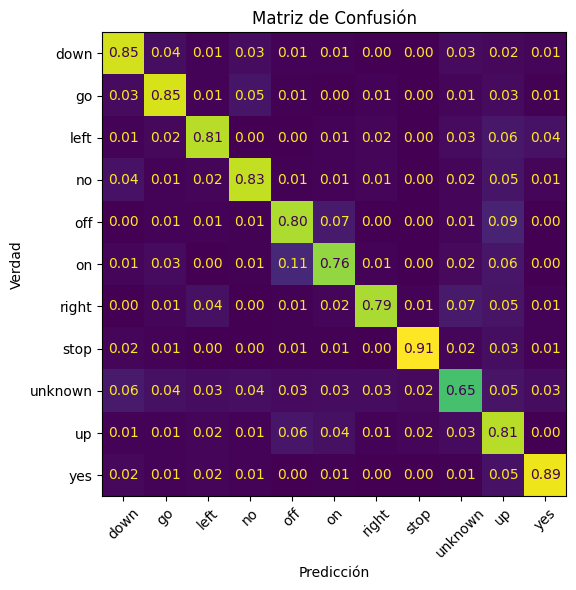

              precision    recall  f1-score   support

        down       0.80      0.85      0.82       396
          go       0.83      0.85      0.84       396
        left       0.84      0.81      0.83       396
          no       0.84      0.83      0.84       396
         off       0.78      0.80      0.79       396
          on       0.80      0.76      0.78       396
       right       0.90      0.79      0.84       396
        stop       0.94      0.91      0.92       396
     unknown       0.75      0.65      0.69       421
          up       0.63      0.81      0.71       396
         yes       0.88      0.89      0.88       396

    accuracy                           0.81      4381
   macro avg       0.82      0.81      0.81      4381
weighted avg       0.82      0.81      0.81      4381

Precisión global (Accuracy): 0.8119


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_h=64")

#### Variación número de capas

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.8675, Train acc: 36.97%
Iteration 168 - Batch 168/508 - Train loss: 1.4944, Train acc: 49.93%
Iteration 252 - Batch 252/508 - Train loss: 1.2831, Train acc: 57.07%
Iteration 336 - Batch 336/508 - Train loss: 1.1544, Train acc: 61.31%
Iteration 420 - Batch 420/508 - Train loss: 1.0655, Train acc: 64.36%
Iteration 504 - Batch 504/508 - Train loss: 0.9929, Train acc: 66.75%
Val loss: 0.6429, Val acc: 78.94%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.5962, Train acc: 80.13%
Iteration 676 - Batch 168/508 - Train loss: 0.5925, Train acc: 80.11%
Iteration 760 - Batch 252/508 - Trai

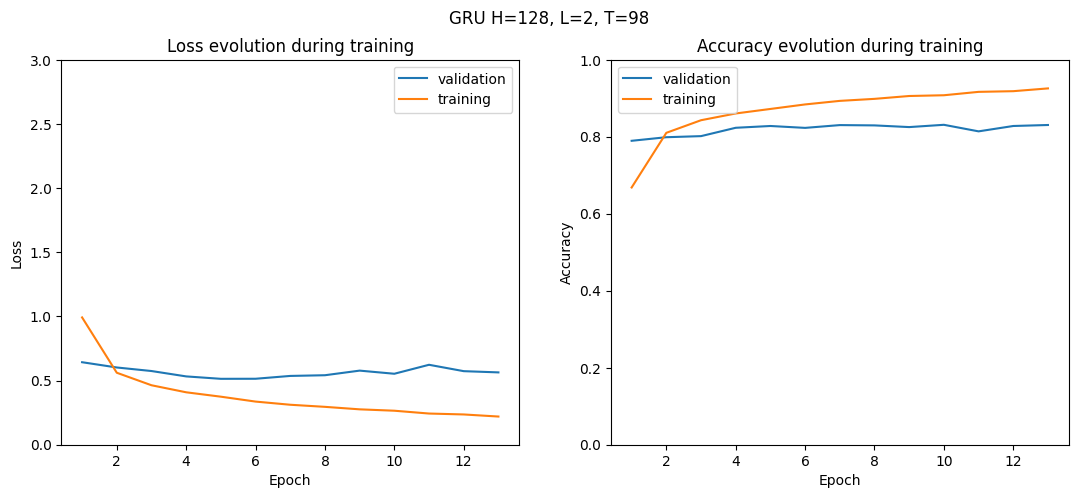

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(98, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=2,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="GRU H=128, L=2, T=98", filename="gru_L=2.png")

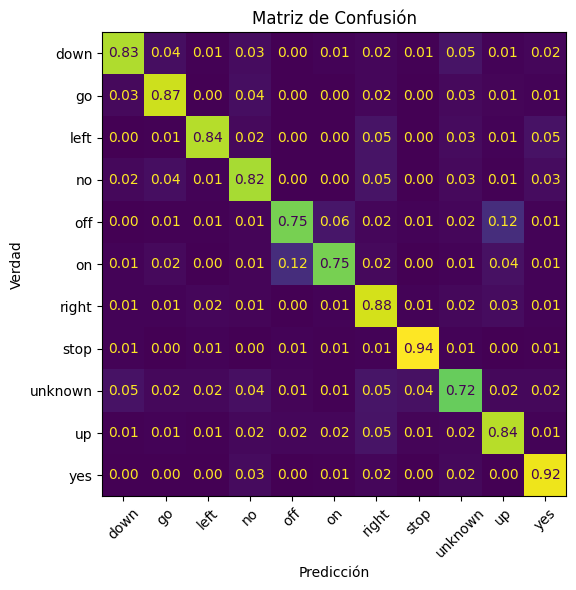

              precision    recall  f1-score   support

        down       0.86      0.83      0.84       396
          go       0.86      0.87      0.86       396
        left       0.91      0.84      0.87       396
          no       0.79      0.82      0.80       396
         off       0.81      0.75      0.78       396
          on       0.87      0.75      0.80       396
       right       0.74      0.88      0.81       396
        stop       0.92      0.94      0.93       396
     unknown       0.77      0.72      0.75       421
          up       0.77      0.84      0.80       396
         yes       0.85      0.92      0.88       396

    accuracy                           0.83      4381
   macro avg       0.83      0.83      0.83      4381
weighted avg       0.83      0.83      0.83      4381

Precisión global (Accuracy): 0.8299


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_L=2")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.5944, Train acc: 47.08%
Iteration 168 - Batch 168/508 - Train loss: 1.2619, Train acc: 58.16%
Iteration 252 - Batch 252/508 - Train loss: 1.1029, Train acc: 63.41%
Iteration 336 - Batch 336/508 - Train loss: 1.0004, Train acc: 66.71%
Iteration 420 - Batch 420/508 - Train loss: 0.9289, Train acc: 69.04%
Iteration 504 - Batch 504/508 - Train loss: 0.8739, Train acc: 70.84%
Val loss: 0.6632, Val acc: 77.29%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.5181, Train acc: 82.92%
Iteration 676 - Batch 168/508 - Train loss: 0.5157, Train acc: 82.66%
Iteration 760 - Batch 252/508 - Trai

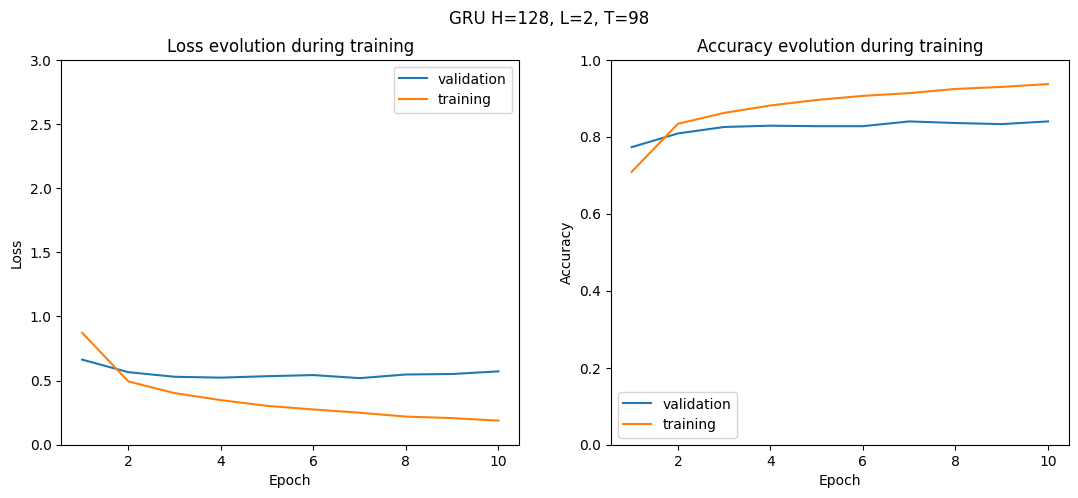

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(98, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=2,
                   bidirectional=True, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="GRU H=128, L=2, T=98", filename="gru_L=2.png")

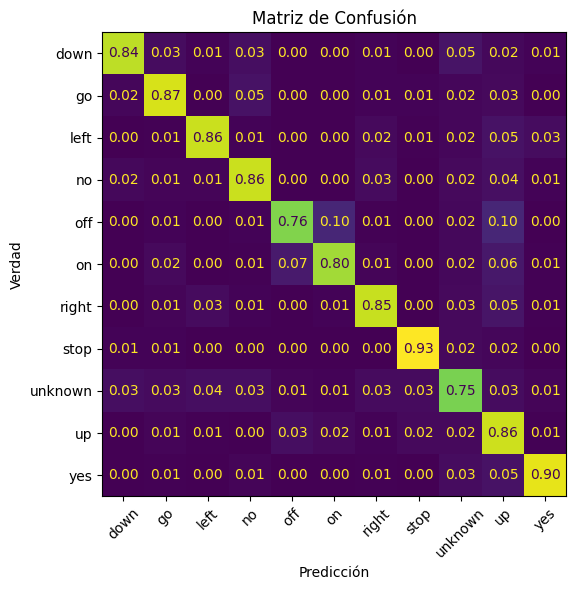

              precision    recall  f1-score   support

        down       0.90      0.84      0.87       396
          go       0.85      0.87      0.86       396
        left       0.89      0.86      0.88       396
          no       0.85      0.86      0.85       396
         off       0.86      0.76      0.80       396
          on       0.84      0.80      0.82       396
       right       0.87      0.85      0.86       396
        stop       0.93      0.93      0.93       396
     unknown       0.76      0.75      0.75       421
          up       0.66      0.86      0.75       396
         yes       0.92      0.90      0.91       396

    accuracy                           0.84      4381
   macro avg       0.85      0.84      0.84      4381
weighted avg       0.85      0.84      0.84      4381

Precisión global (Accuracy): 0.8427


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_tr=2")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.7599, Train acc: 48.00%
Iteration 168 - Batch 168/508 - Train loss: 1.3584, Train acc: 60.03%
Iteration 252 - Batch 252/508 - Train loss: 1.1492, Train acc: 65.88%
Iteration 336 - Batch 336/508 - Train loss: 1.0169, Train acc: 69.59%
Iteration 420 - Batch 420/508 - Train loss: 0.9206, Train acc: 72.32%
Iteration 504 - Batch 504/508 - Train loss: 0.8459, Train acc: 74.41%
Val loss: 0.4546, Val acc: 85.57%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.4142, Train acc: 87.15%
Iteration 676 - Batch 168/508 - Train loss: 0.4027, Train acc: 87.48%
Iteration 760 - Batch 252/508 - Trai

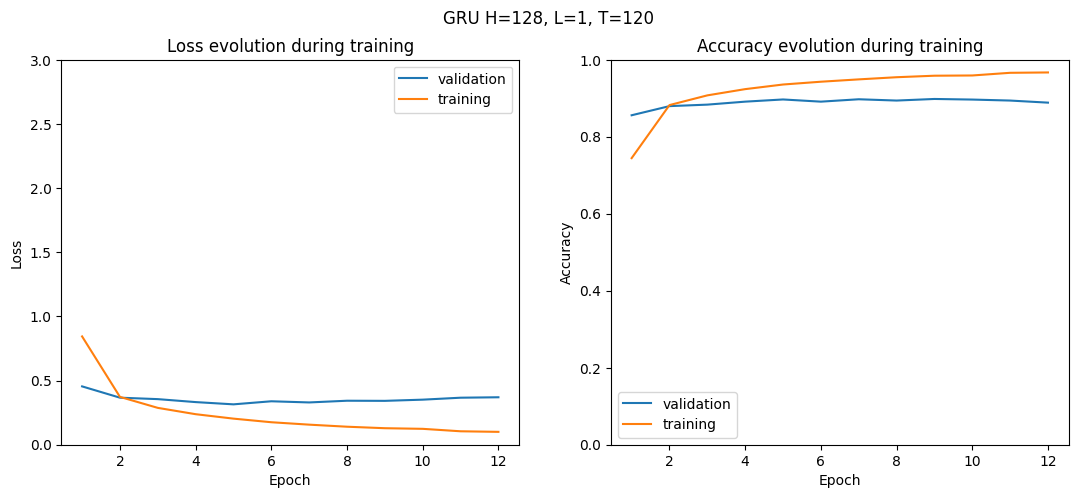

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(120, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=True, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="GRU H=128, L=1, T=120", filename="gru_L=2.png")

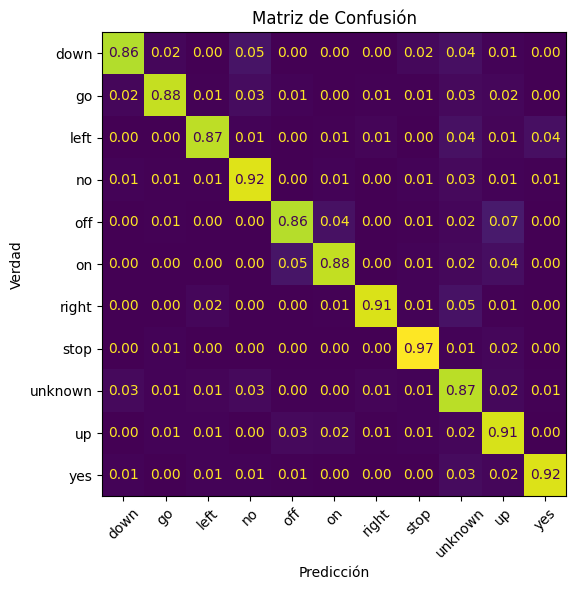

              precision    recall  f1-score   support

        down       0.93      0.86      0.89       396
          go       0.94      0.88      0.91       396
        left       0.94      0.87      0.90       396
          no       0.87      0.92      0.90       396
         off       0.89      0.86      0.88       396
          on       0.90      0.88      0.89       396
       right       0.96      0.91      0.94       396
        stop       0.93      0.97      0.95       396
     unknown       0.78      0.87      0.82       421
          up       0.81      0.91      0.86       396
         yes       0.94      0.92      0.93       396

    accuracy                           0.89      4381
   macro avg       0.90      0.89      0.90      4381
weighted avg       0.90      0.89      0.90      4381

Precisión global (Accuracy): 0.8948


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_tr=2")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.1768, Train acc: 24.82%
Iteration 168 - Batch 168/508 - Train loss: 2.0232, Train acc: 30.48%
Iteration 252 - Batch 252/508 - Train loss: 1.9375, Train acc: 32.99%
Iteration 336 - Batch 336/508 - Train loss: 1.8818, Train acc: 34.82%
Iteration 420 - Batch 420/508 - Train loss: 1.8383, Train acc: 36.20%
Iteration 504 - Batch 504/508 - Train loss: 1.8059, Train acc: 37.09%
Val loss: 1.6799, Val acc: 40.39%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 1.5886, Train acc: 43.33%
Iteration 676 - Batch 168/508 - Train loss: 1.5795, Train acc: 43.79%
Iteration 760 - Batch 252/508 - Trai

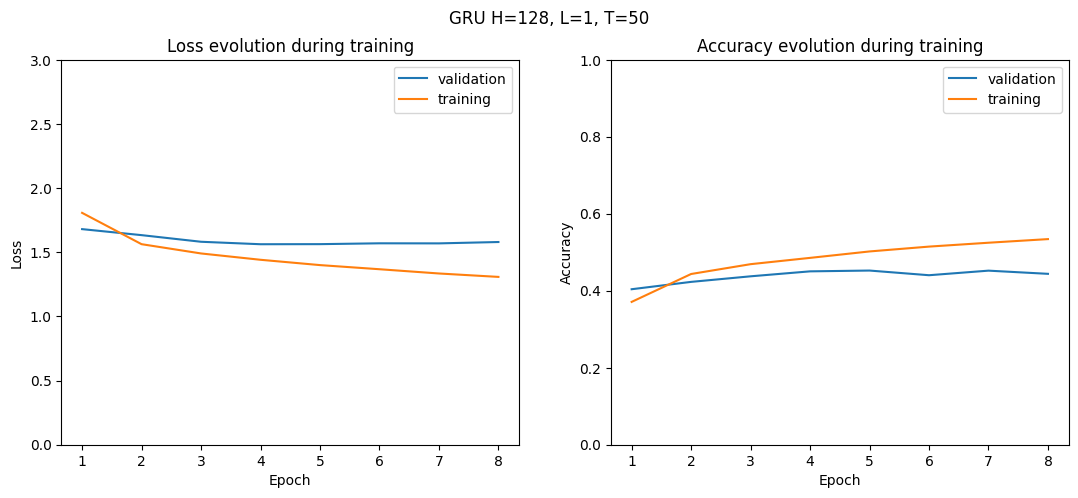

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(50, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=True, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="GRU H=128, L=1, T=50", filename="gru_L=2.png")

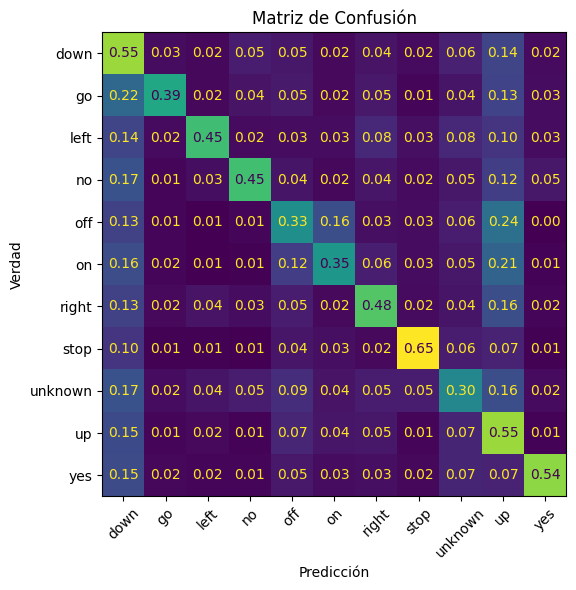

              precision    recall  f1-score   support

        down       0.27      0.55      0.36       396
          go       0.70      0.39      0.50       396
        left       0.70      0.45      0.55       396
          no       0.65      0.45      0.53       396
         off       0.35      0.33      0.34       396
          on       0.46      0.35      0.40       396
       right       0.51      0.48      0.50       396
        stop       0.72      0.65      0.69       396
     unknown       0.36      0.30      0.33       421
          up       0.28      0.55      0.37       396
         yes       0.74      0.54      0.63       396

    accuracy                           0.46      4381
   macro avg       0.52      0.46      0.47      4381
weighted avg       0.52      0.46      0.47      4381

Precisión global (Accuracy): 0.4581


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_tr=2")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.0174, Train acc: 33.64%
Iteration 168 - Batch 168/508 - Train loss: 1.7094, Train acc: 46.71%
Iteration 252 - Batch 252/508 - Train loss: 1.4627, Train acc: 55.09%
Iteration 336 - Batch 336/508 - Train loss: 1.2876, Train acc: 60.55%
Iteration 420 - Batch 420/508 - Train loss: 1.1596, Train acc: 64.50%
Iteration 504 - Batch 504/508 - Train loss: 1.0600, Train acc: 67.49%
Val loss: 0.5439, Val acc: 82.74%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.4973, Train acc: 84.61%
Iteration 676 - Batch 168/508 - Train loss: 0.4825, Train acc: 85.32%
Iteration 760 - Batch 252/508 - Trai

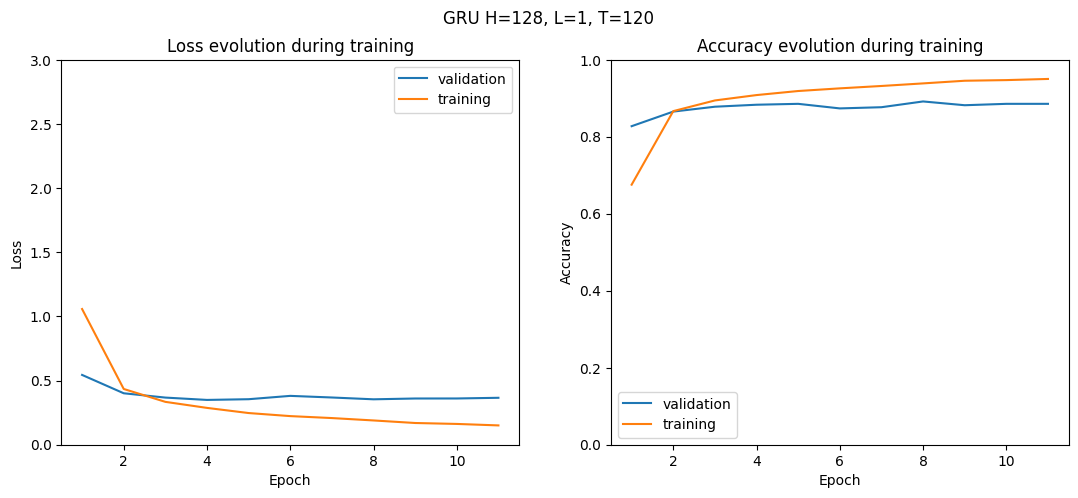

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(120, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="GRU H=128, L=1, T=120", filename="gru_L=2.png")

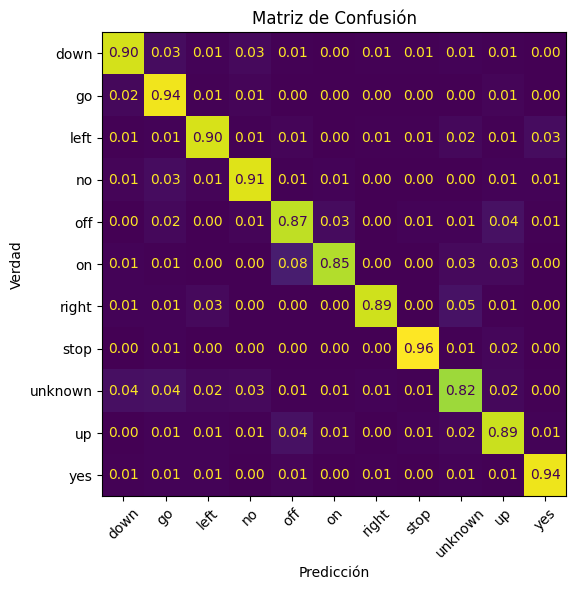

              precision    recall  f1-score   support

        down       0.89      0.90      0.90       396
          go       0.84      0.94      0.89       396
        left       0.91      0.90      0.91       396
          no       0.91      0.91      0.91       396
         off       0.84      0.87      0.85       396
          on       0.93      0.85      0.89       396
       right       0.97      0.89      0.93       396
        stop       0.95      0.96      0.96       396
     unknown       0.86      0.82      0.84       421
          up       0.86      0.89      0.87       396
         yes       0.94      0.94      0.94       396

    accuracy                           0.90      4381
   macro avg       0.90      0.90      0.90      4381
weighted avg       0.90      0.90      0.90      4381

Precisión global (Accuracy): 0.8980


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_tr=2")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.9929, Train acc: 34.26%
Iteration 168 - Batch 168/508 - Train loss: 1.6149, Train acc: 48.10%
Iteration 252 - Batch 252/508 - Train loss: 1.3577, Train acc: 56.47%
Iteration 336 - Batch 336/508 - Train loss: 1.1902, Train acc: 61.82%
Iteration 420 - Batch 420/508 - Train loss: 1.0850, Train acc: 65.25%
Iteration 504 - Batch 504/508 - Train loss: 1.0008, Train acc: 68.08%
Val loss: 0.5166, Val acc: 83.77%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.4753, Train acc: 85.13%
Iteration 676 - Batch 168/508 - Train loss: 0.4614, Train acc: 85.56%
Iteration 760 - Batch 252/508 - Trai

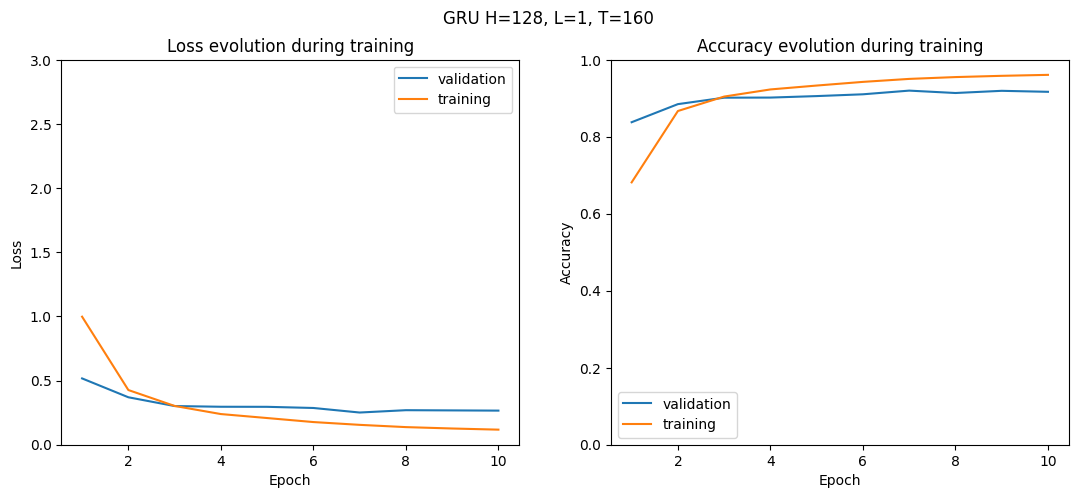

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(160, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="GRU H=128, L=1, T=160", filename="gru_L=2.png")

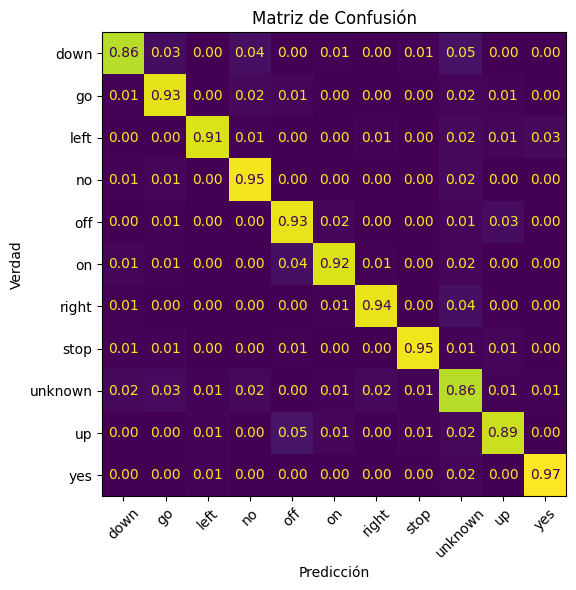

              precision    recall  f1-score   support

        down       0.92      0.86      0.89       396
          go       0.90      0.93      0.91       396
        left       0.96      0.91      0.94       396
          no       0.91      0.95      0.93       396
         off       0.89      0.93      0.91       396
          on       0.95      0.92      0.93       396
       right       0.96      0.94      0.95       396
        stop       0.97      0.95      0.96       396
     unknown       0.80      0.86      0.83       421
          up       0.91      0.89      0.90       396
         yes       0.96      0.97      0.96       396

    accuracy                           0.92      4381
   macro avg       0.92      0.92      0.92      4381
weighted avg       0.92      0.92      0.92      4381

Precisión global (Accuracy): 0.9187


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_tr=2")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.7868, Train acc: 37.02%
Iteration 168 - Batch 168/508 - Train loss: 1.4299, Train acc: 50.75%
Iteration 252 - Batch 252/508 - Train loss: 1.1717, Train acc: 60.06%
Iteration 336 - Batch 336/508 - Train loss: 1.0135, Train acc: 65.70%
Iteration 420 - Batch 420/508 - Train loss: 0.9056, Train acc: 69.47%
Iteration 504 - Batch 504/508 - Train loss: 0.8251, Train acc: 72.31%
Val loss: 0.3736, Val acc: 88.31%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.3588, Train acc: 88.38%
Iteration 676 - Batch 168/508 - Train loss: 0.3402, Train acc: 88.87%
Iteration 760 - Batch 252/508 - Trai

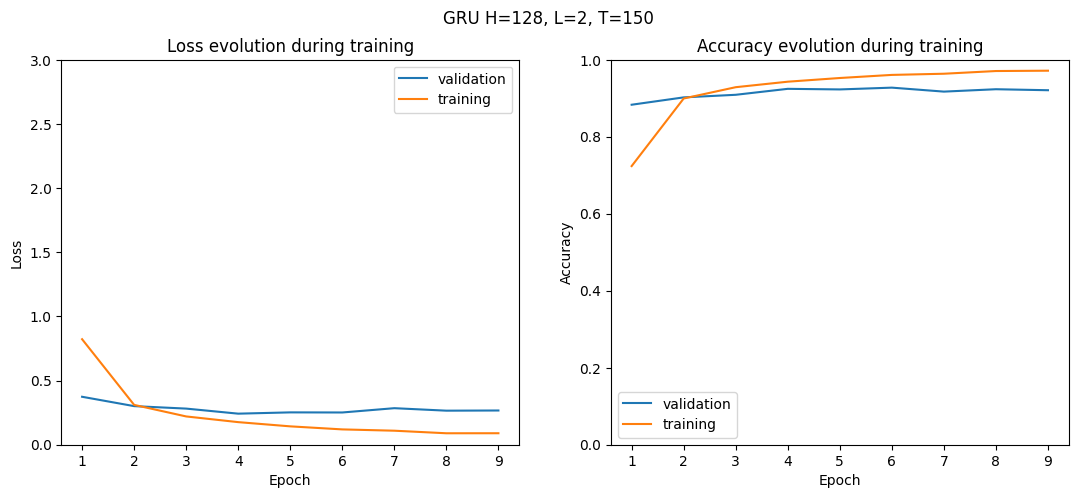

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(150, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=2,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="GRU H=128, L=2, T=150", filename="gru_L=2.png")

### Modelo LSTM

#### Variación número de neuronas por capa

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.2278, Train acc: 21.95%
Iteration 168 - Batch 168/508 - Train loss: 1.9890, Train acc: 33.91%
Iteration 252 - Batch 252/508 - Train loss: 1.7785, Train acc: 42.15%
Iteration 336 - Batch 336/508 - Train loss: 1.6118, Train acc: 48.11%
Iteration 420 - Batch 420/508 - Train loss: 1.4845, Train acc: 52.17%
Iteration 504 - Batch 504/508 - Train loss: 1.3855, Train acc: 55.37%
Val loss: 0.8611, Val acc: 71.77%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.8189, Train acc: 73.35%
Iteration 676 - Batch 168/508 - Train loss: 0.7928, Train acc: 74.43%
Iteration 760 - Batch 252/508 - Trai

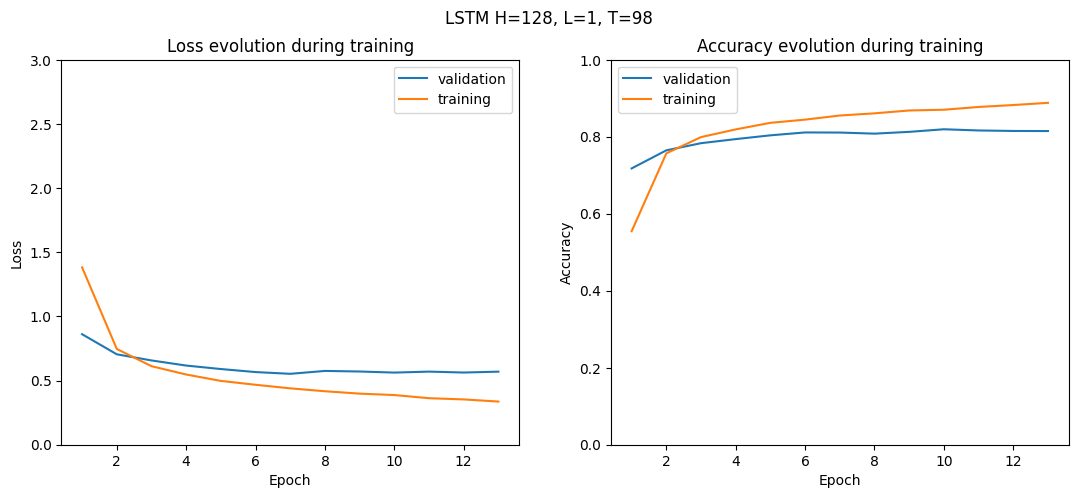

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(98, batch_size=64)

model = LSTMModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="LSTM H=128, L=1, T=98", filename="LSTM_H=128.png")

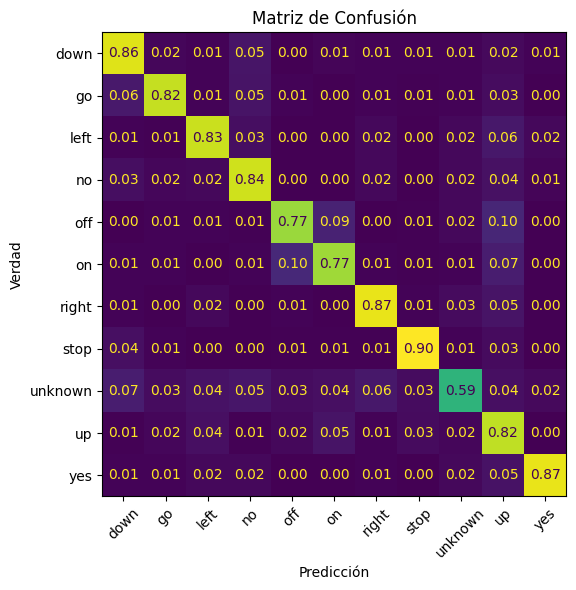

              precision    recall  f1-score   support

        down       0.77      0.86      0.81       396
          go       0.88      0.82      0.85       396
        left       0.83      0.83      0.83       396
          no       0.78      0.84      0.81       396
         off       0.81      0.77      0.79       396
          on       0.79      0.77      0.78       396
       right       0.86      0.87      0.86       396
        stop       0.90      0.90      0.90       396
     unknown       0.80      0.59      0.68       421
          up       0.63      0.82      0.71       396
         yes       0.93      0.87      0.90       396

    accuracy                           0.81      4381
   macro avg       0.82      0.81      0.81      4381
weighted avg       0.82      0.81      0.81      4381

Precisión global (Accuracy): 0.8105


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_L=2")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.0201, Train acc: 31.16%
Iteration 168 - Batch 168/508 - Train loss: 1.6648, Train acc: 44.68%
Iteration 252 - Batch 252/508 - Train loss: 1.4389, Train acc: 52.61%
Iteration 336 - Batch 336/508 - Train loss: 1.2952, Train acc: 57.43%
Iteration 420 - Batch 420/508 - Train loss: 1.1897, Train acc: 61.08%
Iteration 504 - Batch 504/508 - Train loss: 1.1113, Train acc: 63.53%
Val loss: 0.7156, Val acc: 76.41%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.6851, Train acc: 77.81%
Iteration 676 - Batch 168/508 - Train loss: 0.6588, Train acc: 78.72%
Iteration 760 - Batch 252/508 - Trai

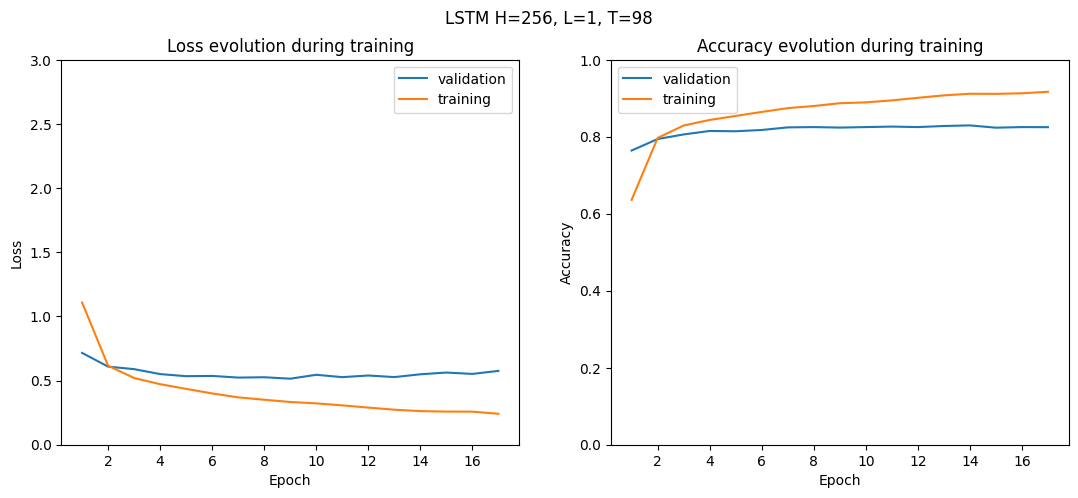

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(98, batch_size=64)

model = LSTMModel(input_size=39, hidden_size=256, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="LSTM H=256, L=1, T=98", filename="LSTM_H=128.png")

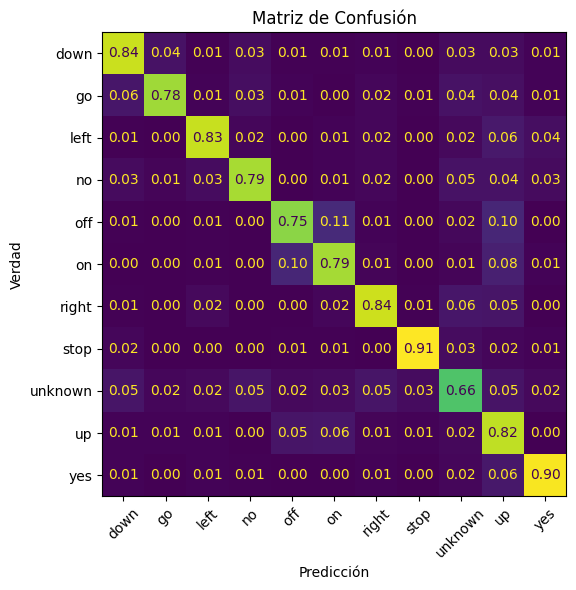

              precision    recall  f1-score   support

        down       0.82      0.84      0.83       396
          go       0.89      0.78      0.83       396
        left       0.88      0.83      0.85       396
          no       0.85      0.79      0.82       396
         off       0.79      0.75      0.77       396
          on       0.77      0.79      0.78       396
       right       0.84      0.84      0.84       396
        stop       0.94      0.91      0.93       396
     unknown       0.70      0.66      0.68       421
          up       0.61      0.82      0.70       396
         yes       0.88      0.90      0.89       396

    accuracy                           0.81      4381
   macro avg       0.82      0.81      0.81      4381
weighted avg       0.82      0.81      0.81      4381

Precisión global (Accuracy): 0.8087


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizL_de_confusión_H=128")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.2518, Train acc: 20.79%
Iteration 168 - Batch 168/508 - Train loss: 2.0828, Train acc: 29.31%
Iteration 252 - Batch 252/508 - Train loss: 1.9165, Train acc: 36.85%
Iteration 336 - Batch 336/508 - Train loss: 1.7644, Train acc: 42.93%
Iteration 420 - Batch 420/508 - Train loss: 1.6321, Train acc: 47.93%
Iteration 504 - Batch 504/508 - Train loss: 1.5249, Train acc: 51.64%
Val loss: 0.8519, Val acc: 73.99%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.8149, Train acc: 75.07%
Iteration 676 - Batch 168/508 - Train loss: 0.7707, Train acc: 76.34%
Iteration 760 - Batch 252/508 - Trai

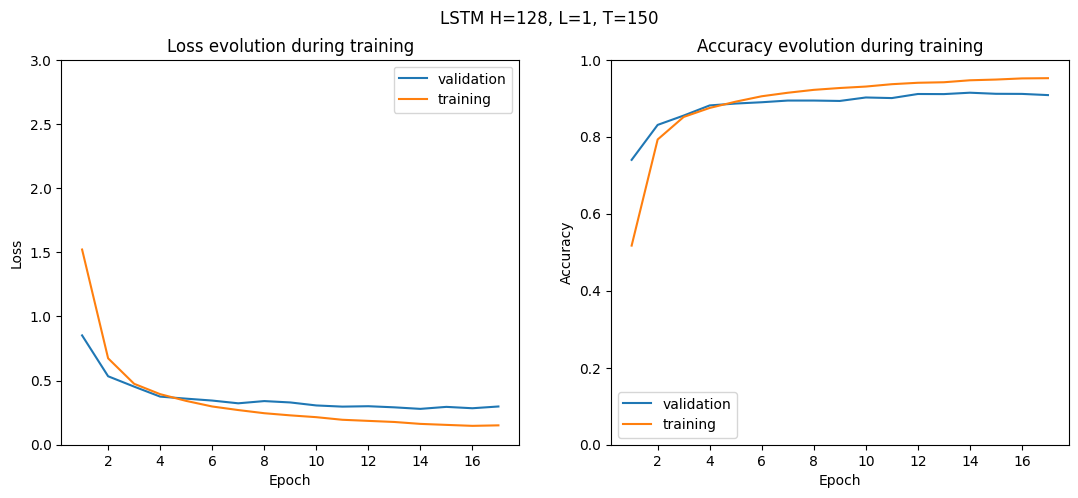

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(150, batch_size=64)

model = LSTMModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="LSTM H=128, L=1, T=150", filename="LSTM_H=256.png")

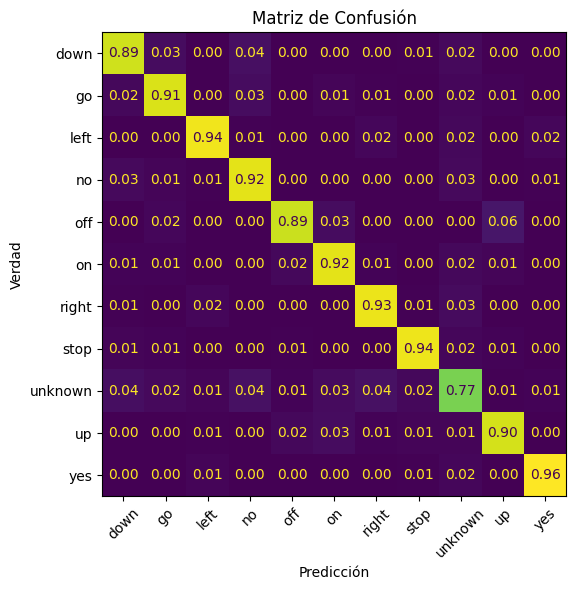

              precision    recall  f1-score   support

        down       0.88      0.89      0.89       396
          go       0.89      0.91      0.90       396
        left       0.94      0.94      0.94       396
          no       0.88      0.92      0.90       396
         off       0.94      0.89      0.91       396
          on       0.89      0.92      0.91       396
       right       0.92      0.93      0.93       396
        stop       0.95      0.94      0.94       396
     unknown       0.82      0.77      0.79       421
          up       0.90      0.90      0.90       396
         yes       0.96      0.96      0.96       396

    accuracy                           0.91      4381
   macro avg       0.91      0.91      0.91      4381
weighted avg       0.91      0.91      0.91      4381

Precisión global (Accuracy): 0.9064


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizL_de_confusión_H=256")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.2827, Train acc: 18.79%
Iteration 168 - Batch 168/508 - Train loss: 2.1699, Train acc: 23.83%
Iteration 252 - Batch 252/508 - Train loss: 2.0775, Train acc: 27.29%
Iteration 336 - Batch 336/508 - Train loss: 2.0168, Train acc: 29.28%
Iteration 420 - Batch 420/508 - Train loss: 1.9673, Train acc: 30.96%
Iteration 504 - Batch 504/508 - Train loss: 1.9282, Train acc: 32.43%
Val loss: 1.7478, Val acc: 38.30%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 1.7000, Train acc: 40.44%
Iteration 676 - Batch 168/508 - Train loss: 1.6843, Train acc: 40.66%
Iteration 760 - Batch 252/508 - Trai

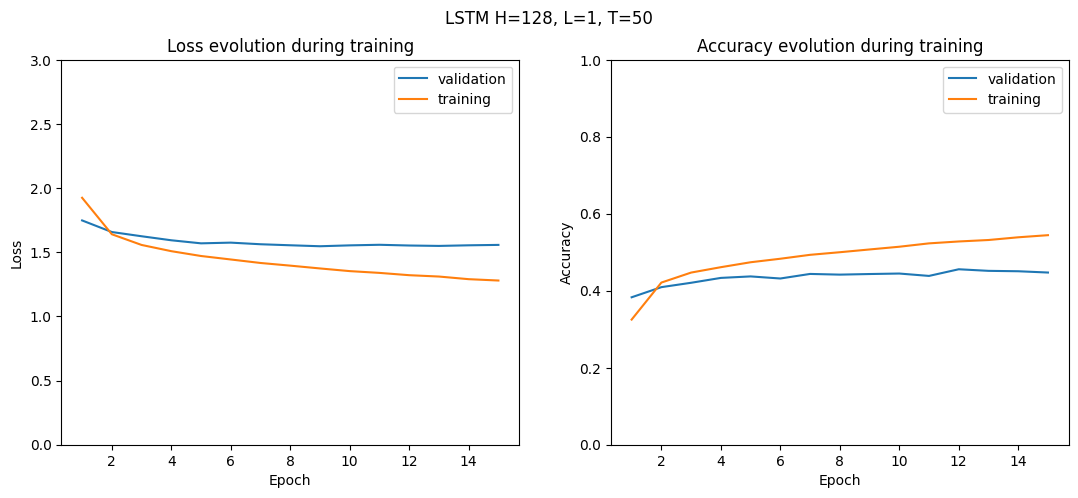

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = adjust_length(50, batch_size=64)

model = LSTMModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=3
)

show_curves(curves, title="LSTM H=128, L=1, T=50", filename="LSTM_H=256.png")

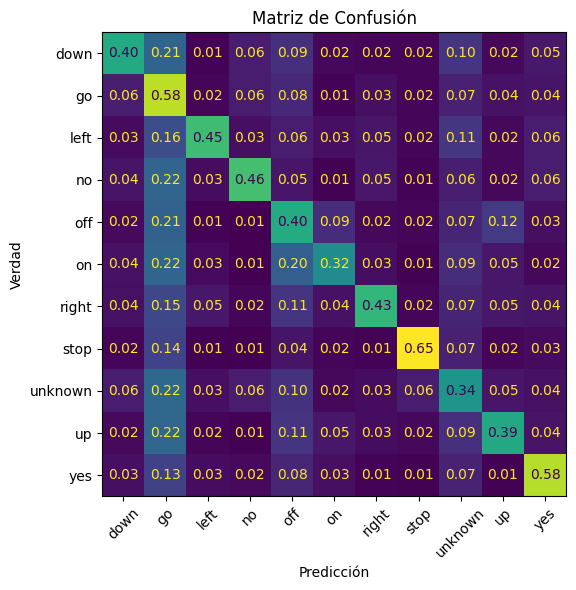

              precision    recall  f1-score   support

        down       0.53      0.40      0.45       396
          go       0.24      0.58      0.34       396
        left       0.66      0.45      0.53       396
          no       0.62      0.46      0.53       396
         off       0.31      0.40      0.35       396
          on       0.49      0.32      0.39       396
       right       0.61      0.43      0.51       396
        stop       0.77      0.65      0.70       396
     unknown       0.31      0.34      0.32       421
          up       0.50      0.39      0.44       396
         yes       0.59      0.58      0.58       396

    accuracy                           0.45      4381
   macro avg       0.51      0.45      0.47      4381
weighted avg       0.51      0.45      0.47      4381

Precisión global (Accuracy): 0.4529


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizL_de_confusión_H=256")